# Instalasi & Import

In [1]:
# ================================================================================
# Cell 1: Install & Import Libraries
# ================================================================================
# Instalasi library yang diperlukan (suppress output untuk cleaner notebook)
!pip install -q xgboost optuna shap plotly kaleido

# ================================================================================
# IMPORT LIBRARIES
# ================================================================================

# --- Core Libraries ---
import os
import sys
import time
import warnings
from datetime import datetime

# --- Data Processing ---
import numpy as np
import pandas as pd

# --- Visualization ---
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly. express as px
import plotly.graph_objects as go

# --- Machine Learning Core ---
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    f1_score, 
    accuracy_score, 
    precision_score, 
    recall_score,
    cohen_kappa_score,
    roc_auc_score
)
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_selection import SelectFromModel

# --- Optimization ---
import optuna
from optuna.samplers import TPESampler, NSGAIISampler, RandomSampler
from optuna.pruners import SuccessiveHalvingPruner, MedianPruner

# --- Interpretability ---
import shap

# --- Statistical Testing ---
from scipy. stats import kruskal

# ================================================================================
# KONFIGURASI ENVIRONMENT
# ================================================================================

# Suppress warnings untuk output yang lebih bersih
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Pandas display options (FIXED:  hapus semua spasi di nama opsi!)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)  # ❌ SEBELUMNYA:  'display.  max_rows' (ada spasi!)
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.width', 1000)

# Matplotlib & Seaborn styling
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 11

# Plotly rendering (untuk Kaggle/Jupyter)
pio.renderers.default = "iframe"  # Agar grafik interaktif muncul di Kaggle

# Seed untuk reprodusibilitas
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ================================================================================
# VERIFIKASI INSTALASI & GPU
# ================================================================================

print("="*80)
print("🚀 SETUP ENVIRONMENT - NETWORK INTRUSION DETECTION SYSTEM")
print("="*80)
print(f"📅 Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🐍 Python Version: {sys.version. split()[0]}")
print()

# --- Verifikasi Library Versions ---
print("📦 Library Versions:")
print(f"   ├─ NumPy:          {np.__version__}")
print(f"   ├─ Pandas:        {pd.__version__}")
print(f"   ├─ XGBoost:       {xgb.__version__} {'✅ (v2.0+)' if int(xgb.__version__.split('.')[0]) >= 2 else '⚠️ (Perlu update! )'}")
print(f"   ├─ Optuna:         {optuna.__version__}")
print(f"   ├─ SHAP:          {shap.__version__}")
print(f"   ├─ Matplotlib:    {plt.matplotlib.__version__}")
print(f"   └─ Seaborn:       {sns.__version__}")
print()

# --- Verifikasi GPU/CUDA ---
print("🖥️  Hardware & Compute:")
try:
    # Check XGBoost GPU support
    xgb_build_info = xgb.build_info()
    use_cuda = xgb_build_info.get('USE_CUDA', False)
    
    if use_cuda:
        print(f"   ├─ GPU Status:     ✅ CUDA ENABLED")
        
        # Try to get more GPU info (jika menggunakan environment dengan nvidia-smi)
        try:
            gpu_info = ! nvidia-smi --query-gpu=name,memory.total --format=csv,noheader
            if gpu_info:
                gpu_name, gpu_mem = gpu_info[0].split(', ')
                print(f"   ├─ GPU Device:    {gpu_name}")
                print(f"   └─ GPU Memory:    {gpu_mem}")
        except:
            print(f"   └─ GPU Device:    (Info tidak tersedia)")
    else:
        print(f"   └─ GPU Status:    ⚠️  CUDA NOT AVAILABLE (akan menggunakan CPU)")
        print(f"                     Tip: Aktifkan GPU di Kaggle Settings → Accelerator")
except Exception as e: 
    print(f"   └─ GPU Status:    ⚠️  Error checking GPU: {str(e)}")
print()

# --- Verifikasi Memory ---
try:
    import psutil
    mem = psutil.virtual_memory()
    print(f"💾 System Memory:")
    print(f"   ├─ Total RAM:     {mem.total / (1024**3):.2f} GB")
    print(f"   ├─ Available:      {mem.available / (1024**3):.2f} GB")
    print(f"   └─ Used:          {mem.percent:.1f}%")
except ImportError:
    print(f"💾 System Memory:     (psutil tidak tersedia)")
print()

# --- Konfigurasi Global untuk Penelitian ---
print("⚙️  Research Configuration:")
print(f"   ├─ Random Seed:   {RANDOM_SEED}")
print(f"   ├─ Train/Test:     80/20 (stratified)")
print(f"   ├─ Validation:    20% from train (stratified)")
print(f"   ├─ Optuna Trials: 30 per sampler")
print(f"   └─ Samplers:      TPE, NSGA-II, Random")
print()

# --- Verifikasi XGBoost GPU Capability ---
print("🔬 XGBoost Configuration Test:")
try:
    # Test apakah XGBoost bisa menggunakan GPU
    test_params = {'tree_method': 'hist', 'device': 'cuda'}
    test_model = xgb.XGBClassifier(**test_params, n_estimators=1, random_state=42)
    
    # Create dummy data
    X_test = np.random.rand(100, 10)
    y_test = np.random.randint(0, 2, 100)
    
    # Try to fit
    test_model. fit(X_test, y_test, verbose=False)
    print(f"   └─ GPU Training:   ✅ Successfully tested XGBoost GPU training")
except Exception as e: 
    print(f"   └─ GPU Training:  ⚠️  GPU test failed, akan fallback ke CPU")
    print(f"                     Error: {str(e)}")
print()

print("="*80)
print("✅ SETUP COMPLETED SUCCESSFULLY!")
print("="*80)
print()

# ================================================================================
# HELPER FUNCTIONS (Opsional - untuk debugging)
# ================================================================================

def check_gpu_availability():
    """Quick function to check GPU status"""
    try:
        build_info = xgb.build_info()
        return build_info.get('USE_CUDA', False)
    except:
        return False

def print_dataset_info(df, name="Dataset"):
    """Helper function to print dataset information"""
    print(f"\n📊 {name} Information:")
    print(f"   ├─ Shape:         {df.shape[0]: ,} rows × {df.shape[1]} columns")
    print(f"   ├─ Memory:         {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
    print(f"   ├─ Duplicates:    {df.duplicated().sum():,}")
    print(f"   └─ Missing:        {df.isnull().sum().sum():,} values")

# Simpan timestamp untuk tracking waktu eksekusi
setup_time = datetime.now()
print(f"⏱️  Setup completed at: {setup_time.strftime('%H:%M:%S')}")
print()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.6 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


🚀 SETUP ENVIRONMENT - NETWORK INTRUSION DETECTION SYSTEM
📅 Timestamp: 2026-02-06 12:44:42
🐍 Python Version: 3.12.12

📦 Library Versions:
   ├─ NumPy:          2.0.2
   ├─ Pandas:        2.2.2
   ├─ XGBoost:       3.1.0 ✅ (v2.0+)
   ├─ Optuna:         2.10.1
   ├─ SHAP:          0.49.1
   ├─ Matplotlib:    3.10.0
   └─ Seaborn:       0.13.2

🖥️  Hardware & Compute:
   ├─ GPU Status:     ✅ CUDA ENABLED
   ├─ GPU Device:    Tesla P100-PCIE-16GB
   └─ GPU Memory:    16384 MiB

💾 System Memory:
   ├─ Total RAM:     31.35 GB
   ├─ Available:      29.79 GB
   └─ Used:          5.0%

⚙️  Research Configuration:
   ├─ Random Seed:   42
   ├─ Train/Test:     80/20 (stratified)
   ├─ Validation:    20% from train (stratified)
   ├─ Optuna Trials: 30 per sampler
   └─ Samplers:      TPE, NSGA-II, Random

🔬 XGBoost Configuration Test:
   └─ GPU Training:   ✅ Successfully tested XGBoost GPU training

✅ SETUP COMPLETED SUCCESSFULLY!

⏱️  Setup completed at: 12:44:43



# Load Dataset (Otomatis)

In [2]:
# ================================================================================
# Cell 2: Load Data, Class Mapping & Initial Split (UPDATED)
# ================================================================================

import pandas as pd
import numpy as np
import os
import gc
from sklearn.model_selection import train_test_split

# ================================================================================
# BAGIAN 1: AUTO-DETECT & LOAD DATASET
# ================================================================================

print("=" * 80)
print("📂 LOADING DATASET NF-UNSW-NB15-v3")
print("=" * 80)
print("\n🔍 Mencari file dataset di /kaggle/input/ ...")

data_path = None

# Auto-detect file dataset
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if (
            filename.lower().endswith(".csv")
            and "unsw" in filename.lower()
            and "features" not in filename.lower()
        ):
            data_path = os.path.join(dirname, filename)
            print(f"✅ Ditemukan file: {filename}")
            print(f"   Path: {data_path}")
            break
    if data_path:
        break

# Fallback manual path
if not data_path:
    print("⚠️  Auto-detect gagal, menggunakan path manual...")
    data_path = '/kaggle/input/nf-unsw-nb15-v3/NF-UNSW-NB15-v3.csv'
    if not os.path.exists(data_path):
        raise FileNotFoundError(
            "❌ File data tidak ditemukan!\n"
            "   Pastikan dataset sudah di-add ke Kaggle Notebook Anda.\n"
            f"   Path yang dicoba: {data_path}"
        )

# Load dataset
print("\n⏳ Membaca dataset (ukuran besar, mohon tunggu)...")
start_time = pd.Timestamp.now()

# Optimasi: Tentukan tipe data untuk hemat memori saat load jika memungkinkan
# Namun load full dulu agar aman, baru di-cast nanti
df_full = pd.read_csv(data_path)

load_time = (pd.Timestamp.now() - start_time).total_seconds()
print(f"✅ Dataset berhasil dimuat dalam {load_time:.2f} detik")

# ================================================================================
# BAGIAN 2: PEMETAAN KATEGORI (CLASS MAPPING) - SESUAI BAB 3
# ================================================================================
# Ini adalah bagian yang ditambahkan untuk mengubah label sesuai tabel Skripsi
# 0: Normal, 1: DoS, 2: Probe, 3: Malware

print("\n" + "=" * 80)
print("🔄 TRANSFORMASI KATEGORI (MAPPING)")
print("=" * 80)

# 1. Identifikasi Kolom Kategori Asli
# Di NF-UNSW-NB15-v3, kolom nama serangan biasanya 'Attack'
if 'Attack' in df_full.columns:
    source_col = 'Attack'
elif 'attack_cat' in df_full.columns:
    source_col = 'attack_cat'
else:
    # Fallback jika nama kolom berbeda, kita coba cari kolom object yang punya nilai 'Benign'
    obj_cols = df_full.select_dtypes(include=['object']).columns
    source_col = None
    for col in obj_cols:
        if 'Benign' in df_full[col].unique():
            source_col = col
            break
            
if not source_col:
    raise ValueError("❌ Kolom kategori serangan (misal: 'Attack') tidak ditemukan!")

print(f"✅ Kolom sumber kategori ditemukan: '{source_col}'")
print(f"ℹ️  Jumlah unik awal: {df_full[source_col].nunique()} kategori")

# 2. Definisi Dictionary Mapping (Sesuai Tabel Anda)
mapping_rules = {
    # 0 (Normal)
    'Benign': 0,
    
    # 1 (DoS)
    'DoS': 1,
    'Generic': 1,
    
    # 2 (Probe)
    'Reconnaissance': 2,
    'Analysis': 2,
    
    # 3 (Malware)
    'Exploits': 3,
    'Fuzzers': 3,
    'Backdoor': 3,
    'Shellcode': 3,
    'Worms': 3
}

# 3. Terapkan Mapping
print("\n🛠️  Menerapkan mapping kategori...")
df_full['mapped_label'] = df_full[source_col].map(mapping_rules)

# 4. Validasi Hasil Mapping
unmapped_count = df_full['mapped_label'].isnull().sum()
if unmapped_count > 0:
    print(f"⚠️  PERINGATAN: Ada {unmapped_count} sampel yang tidak ter-mapping!")
    print("   Label yang gagal dimapping:", df_full[df_full['mapped_label'].isnull()][source_col].unique())
    # Opsional: Drop atau masukkan ke kategori lain. Untuk saat ini kita drop agar aman.
    df_full = df_full.dropna(subset=['mapped_label'])
else:
    print("✅ Semua sampel berhasil di-mapping.")

# Ubah ke integer
df_full['mapped_label'] = df_full['mapped_label'].astype(int)

# 5. Set Target Column Baru
target_col = 'mapped_label'

# 6. Tampilkan Distribusi Baru
print("\n📊 DISTRIBUSI KELAS SETELAH MAPPING:")
mapping_names = {0: 'Normal', 1: 'DoS', 2: 'Probe', 3: 'Malware'}
dist_counts = df_full[target_col].value_counts().sort_index()

print(f"{'ID':<5} {'Kategori':<15} {'Jumlah':<15} {'Persentase':<10}")
print("-" * 50)
for label_id, count in dist_counts.items():
    label_name = mapping_names.get(label_id, 'Unknown')
    pct = (count / len(df_full)) * 100
    print(f"{label_id:<5} {label_name:<15} {count:<15,} {pct:<10.2f}%")

# ================================================================================
# BAGIAN 3: ANALISIS DATASET (UPDATE)
# ================================================================================
# Kita skip analisis detail per kolom karena sudah ada di atas, fokus ke cek hasil mapping

# Hapus kolom target lama agar tidak bocor (Data Leakage) saat training nanti
cols_to_drop = ['Label', 'Attack', 'attack_cat'] 
# Hapus hanya jika ada di dataframe dan bukan target baru
cols_to_drop = [c for c in cols_to_drop if c in df_full.columns and c != target_col]

if cols_to_drop:
    print(f"\n🗑️  Menghapus kolom target lama (redundant): {cols_to_drop}")
    df_full.drop(columns=cols_to_drop, inplace=True)

# ================================================================================
# BAGIAN 4: SPLIT TRAIN & TEST (80:20 STRATIFIED)
# ================================================================================

print("\n" + "=" * 80)
print("✂️  PEMBAGIAN DATASET: TRAIN & TEST")
print("=" * 80)
print("ℹ️  Melakukan split 80:20 dengan Stratified Sampling berdasarkan 'mapped_label'")

df_train_full, df_test_raw = train_test_split(
    df_full,
    test_size=0.2,
    random_state=42,
    stratify=df_full[target_col] # Stratify menggunakan label baru
)

print("✅ Split berhasil!")
print(f"   - Train: {df_train_full.shape[0]:,} rows")
print(f"   - Test : {df_test_raw.shape[0]:,} rows")

# Verifikasi Stratifikasi
print("\n🔍 Verifikasi Proporsi Kelas di Data Uji (Test Set):")
test_dist = df_test_raw[target_col].value_counts(normalize=True).sort_index()
for label_id, pct in test_dist.items():
    label_name = mapping_names.get(label_id, 'Unknown')
    print(f"   - Kelas {label_id} ({label_name}): {pct*100:.2f}%")

# ================================================================================
# BAGIAN 5: CLEANUP MEMORY
# ================================================================================

del df_full
gc.collect()

print("\n🧹 Dataset original dihapus dari memori")

# ================================================================================
# RINGKASAN FINAL CELL 2
# ================================================================================

print("\n" + "=" * 80)
print("📋 RINGKASAN FINAL CELL 2")
print("=" * 80)
print(f"✅ Target Baru:     {target_col} (0=Normal, 1=DoS, 2=Probe, 3=Malware)")
print(f"✅ Train set shape: {df_train_full.shape}")
print(f"✅ Test set shape:  {df_test_raw.shape}")
print("=" * 80)

📂 LOADING DATASET NF-UNSW-NB15-v3

🔍 Mencari file dataset di /kaggle/input/ ...
✅ Ditemukan file: NF-UNSW-NB15-v3.csv
   Path: /kaggle/input/nf-unsw-nb15-v3/NF-UNSW-NB15-v3.csv

⏳ Membaca dataset (ukuran besar, mohon tunggu)...
✅ Dataset berhasil dimuat dalam 15.21 detik

🔄 TRANSFORMASI KATEGORI (MAPPING)
✅ Kolom sumber kategori ditemukan: 'Attack'
ℹ️  Jumlah unik awal: 10 kategori

🛠️  Menerapkan mapping kategori...
✅ Semua sampel berhasil di-mapping.

📊 DISTRIBUSI KELAS SETELAH MAPPING:
ID    Kategori        Jumlah          Persentase
--------------------------------------------------
0     Normal          2,237,731       94.60     %
1     DoS             25,631          1.08      %
2     Probe           18,300          0.77      %
3     Malware         83,762          3.54      %

🗑️  Menghapus kolom target lama (redundant): ['Label', 'Attack']

✂️  PEMBAGIAN DATASET: TRAIN & TEST
ℹ️  Melakukan split 80:20 dengan Stratified Sampling berdasarkan 'mapped_label'
✅ Split berhasil!
   - 

# Preprocessing & Class Weights

In [3]:
# ================================================================================
# Cell 3: Preprocessing (CLEANING, ENCODING & WEIGHTING) - FIXED
# ================================================================================

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

# --- 1. KONFIGURASI TARGET ---
# Prioritaskan 'mapped_label' dari Cell 2, jika tidak ada baru cari yang lain
possible_targets = ['mapped_label', 'Attack', 'attack_cat', 'Label'] 
target_col = next((col for col in df_train_full.columns if col in possible_targets), None)

if not target_col:
    raise ValueError("❌ Kolom target tidak ditemukan! Pastikan Cell 2 sudah dijalankan.")

print(f"🎯 Target Kolom Final: '{target_col}'")
print(f"📊 Shape dataset awal (train): {df_train_full.shape}")
print(f"📊 Shape dataset awal (test):  {df_test_raw.shape}")

# --- 2. BERSIHKAN KOLOM IDENTITAS (WAJIB UTK NETFLOW) ---
cols_to_drop = [
    # 1-2. Metadata waktu (tidak konsisten untuk generalisasi)
    'FLOW_START_MILLISECONDS',
    'FLOW_END_MILLISECONDS',
    
    # 3-6. Identitas (risiko overfitting terhadap IP tertentu)
    'IPV4_SRC_ADDR',
    'IPV4_DST_ADDR',
    
    'Label'
]

# Verifikasi kolom ada sebelum drop (untuk TRAIN)
cols_to_drop_safe_train = [col for col in cols_to_drop if col in df_train_full.columns and col != target_col]
print(f"\n🗑️ Kolom yang akan di-drop (TRAIN): {len(cols_to_drop_safe_train)}")
# print(cols_to_drop_safe_train)

# Verifikasi kolom ada sebelum drop (untuk TEST)
cols_to_drop_safe_test = [col for col in cols_to_drop if col in df_test_raw.columns and col != target_col]
# print(f"🗑️ Kolom yang akan di-drop (TEST):  {len(cols_to_drop_safe_test)}")

# Drop kolom untuk TRAIN dan TEST
df_train_clean = df_train_full.drop(columns=cols_to_drop_safe_train, errors='ignore')
df_test_clean = df_test_raw.drop(columns=cols_to_drop_safe_test, errors='ignore')

print(f"\n✅ TRAIN - Kolom awal: {df_train_full.shape[1]} → Setelah drop: {df_train_clean.shape[1]}")
print(f"✅ TEST  - Kolom awal: {df_test_raw.shape[1]} → Setelah drop: {df_test_clean.shape[1]}")

# --- 3. PISAHKAN FITUR (X) & TARGET (y) ---
X_raw = df_train_clean.drop(columns=[target_col], errors='ignore')
y_raw = df_train_clean[target_col]

X_test_final_raw = df_test_clean.drop(columns=[target_col], errors='ignore')
y_test_final_raw = df_test_clean[target_col]

print(f"\n📋 Fitur (X) shape: {X_raw.shape}")
print(f"📋 Target (y) shape: {y_raw.shape}")
print(f"📋 Test Fitur shape: {X_test_final_raw.shape}")

# --- 4. ENCODING FITUR KATEGORIKAL ---
# Mendeteksi kolom object (string)
cat_cols = X_raw.select_dtypes(include=['object']).columns

if len(cat_cols) > 0:
    print(f"\n🔤 Encoding fitur kategorikal: {list(cat_cols)}")
    for col in cat_cols:
        le = LabelEncoder()
        # Gabungkan train + test untuk fit encoder (agar tidak ada unseen categories)
        full_col = pd.concat([X_raw[col], X_test_final_raw[col]], axis=0).astype(str)
        le.fit(full_col)
        
        # Transform
        X_raw[col] = le.transform(X_raw[col].astype(str))
        X_test_final_raw[col] = le.transform(X_test_final_raw[col].astype(str))
    print(f"   ✅ Encoding selesai untuk {len(cat_cols)} kolom kategorikal")
else:
    print("\n✅ Tidak ada fitur kategorikal (semua numerik)")

# --- 5. PEMBERSIHAN DATA (CLEANING) ---
print("\n🧹 Membersihkan Infinity dan NaN values...")

# A. Ganti Infinity dengan NaN
X_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_final_raw.replace([np.inf, -np.inf], np.nan, inplace=True)

# B. Cek jumlah NaN sebelum cleaning
nan_count_before = X_raw.isnull().sum().sum()
print(f"   📌 NaN sebelum cleaning: {nan_count_before:,}")

# C. Isi NaN dengan Median (Lebih aman daripada Mean untuk data jaringan yang miring)
# Kita simpan median dari training data untuk dipakai juga di test data agar konsisten
train_medians = X_raw.median()
X_raw.fillna(train_medians, inplace=True)
X_test_final_raw.fillna(train_medians, inplace=True)

# D. Cek apakah masih ada error
nan_count_after = X_raw.isnull().sum().sum()
inf_count_after = np.isinf(X_raw).values.sum()

print(f"   📌 NaN setelah cleaning: {nan_count_after}")
print(f"   📌 Inf setelah cleaning:  {inf_count_after}")

if inf_count_after > 0 or nan_count_after > 0:
    print("   ⚠️ Masih ada nilai bermasalah! Melakukan pemaksaan 0.")
    X_raw.fillna(0, inplace=True)
    X_test_final_raw.fillna(0, inplace=True)
    print("   ✅ Dipaksa menjadi 0")
else:
    print("   ✅ Data 100% bersih dari Infinity dan NaN")

# --- 6. VALIDASI & ENCODING TARGET ---
print("\n🎯 Menyiapkan Target Label...")
# Pastikan target bertipe integer
y = y_raw.astype(int)
y_test_final = y_test_final_raw.astype(int)

# Label Encoder tetap digunakan untuk memastikan urutan 0, 1, 2, ...
le_target = LabelEncoder()
y = le_target.fit_transform(y)
y_test_final = le_target.transform(y_test_final)

print(f"   📌 Jumlah kelas: {len(le_target.classes_)}")
print(f"   📌 Daftar kelas: {le_target.classes_}")

# Mapping nama kelas (Jika dari Cell 2 sudah berupa angka, kita beri nama manual untuk display)
# Sesuai Cell 2: 0=Normal, 1=DoS, 2=Probe, 3=Malware
class_names_map = {0: 'Normal', 1: 'DoS', 2: 'Probe', 3: 'Malware'}

print("\n   Mapping kelas (Numerik → Nama):")
for i in le_target.classes_:
    count = (y == i).sum()
    pct = (count / len(y)) * 100
    name = class_names_map.get(i, f"Class {i}")
    print(f"      {i} → {name:15s}: {count:8,} ({pct:5.2f}%)")

# --- 7. SCALING (STANDARISASI) ---
print("\n📏 Melakukan Scaling data (StandardScaler)...")
scaler = StandardScaler()

# Fit pada train, transform pada train & test
X_enc = pd.DataFrame(scaler.fit_transform(X_raw), columns=X_raw.columns)
X_test_enc = pd.DataFrame(scaler.transform(X_test_final_raw), columns=X_test_final_raw.columns)

# Optimasi Memori (Convert float64 -> float32)
float_cols = X_enc.select_dtypes(include=['float64']).columns
if len(float_cols) > 0:
    X_enc[float_cols] = X_enc[float_cols].astype('float32')
    X_test_enc[float_cols] = X_test_enc[float_cols].astype('float32')
    print(f"   ✅ {len(float_cols)} kolom dikonversi ke float32 (hemat memori)")

# Finalisasi Data
X_selected = X_enc
X_test_selected = X_test_enc
    
print(f"\n✅ Dataset Siap Proses!")
print(f"   🔹 Jumlah Fitur:  {X_selected.shape[1]}")
print(f"   🔹 Train samples: {X_selected.shape[0]:,}")
print(f"   🔹 Test samples:  {X_test_selected.shape[0]:,}")

# --- 8. SPLIT VALIDATION SET ---
print("\n🔀 Membagi Train → Train + Validation (80:20, stratified)...")
# X_train & y_train nanti dipakai untuk training model
# X_val & y_val dipakai untuk evaluasi saat training (early stopping)
X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

print(f"   ✅ Train Set: {X_train.shape[0]:,} samples")
print(f"   ✅ Val Set:   {X_val.shape[0]:,} samples")

# --- 9. AUTO-WEIGHTING (HYBRID STRATEGY) ---
print("\n⚖️ Menghitung Bobot Kelas (Hybrid: balanced → sqrt → normalize)...")
# Sesuai Bab 3.5.3: Penanganan Imbalance

# A. Hitung bobot balanced standard
raw_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# B. Transformasi sqrt (Untuk memperhalus penalti agar tidak terlalu ekstrem pada kelas minoritas)
sample_weights_train = np.sqrt(raw_weights)

# C. Normalisasi (Agar rata-rata bobot = 1, menjaga stabilitas learning rate)
sample_weights_train = sample_weights_train / sample_weights_train.mean()

print(f"   ✅ Bobot Selesai!")
print(f"   🔹 Min Weight: {sample_weights_train.min():.4f}")
print(f"   🔹 Max Weight: {sample_weights_train.max():.4f}")
print(f"   🔹 Mean Weight: {sample_weights_train.mean():.4f}")

# Tampilkan statistik bobot per kelas
print("\n   Statistik bobot per kelas:")
for i in le_target.classes_:
    mask = (y_train == i)
    if mask.sum() > 0:
        avg_weight = sample_weights_train[mask].mean()
        name = class_names_map.get(i, str(i))
        print(f"      {name:15s}: avg weight = {avg_weight:.4f}")

# ================================================================================
# RINGKASAN FINAL PREPROCESSING
# ================================================================================
print("\n" + "="*80)
print("📊 RINGKASAN PREPROCESSING")
print("="*80)
print(f"✅ Input Train:     {df_train_full.shape[0]:,} rows")
print(f"✅ Final Train:     {X_train.shape[0]:,} rows (untuk training)")
print(f"✅ Final Val:       {X_val.shape[0]:,} rows (untuk evaluasi)")
print(f"✅ Final Test:      {X_test_selected.shape[0]:,} rows (untuk testing akhir)")
print(f"✅ Jumlah Fitur:    {X_train.shape[1]}")
print("="*80)

🎯 Target Kolom Final: 'mapped_label'
📊 Shape dataset awal (train): (1892339, 54)
📊 Shape dataset awal (test):  (473085, 54)

🗑️ Kolom yang akan di-drop (TRAIN): 4

✅ TRAIN - Kolom awal: 54 → Setelah drop: 50
✅ TEST  - Kolom awal: 54 → Setelah drop: 50

📋 Fitur (X) shape: (1892339, 49)
📋 Target (y) shape: (1892339,)
📋 Test Fitur shape: (473085, 49)

✅ Tidak ada fitur kategorikal (semua numerik)

🧹 Membersihkan Infinity dan NaN values...
   📌 NaN sebelum cleaning: 195,882
   📌 NaN setelah cleaning: 0
   📌 Inf setelah cleaning:  0
   ✅ Data 100% bersih dari Infinity dan NaN

🎯 Menyiapkan Target Label...
   📌 Jumlah kelas: 4
   📌 Daftar kelas: [0 1 2 3]

   Mapping kelas (Numerik → Nama):
      0 → Normal         : 1,790,185 (94.60%)
      1 → DoS            :   20,505 ( 1.08%)
      2 → Probe          :   14,640 ( 0.77%)
      3 → Malware        :   67,009 ( 3.54%)

📏 Melakukan Scaling data (StandardScaler)...
   ✅ 49 kolom dikonversi ke float32 (hemat memori)

✅ Dataset Siap Proses!
   🔹

# Visualisasi Data: Distribusi Kelas & Bobot

📊 VISUALISASI DISTRIBUSI DATA & STRATEGI PENANGANAN IMBALANCE

🔹 Distribusi Kelas di Training Set:
   Total samples: 1,513,871
   Total classes: 4

   Tabel Statistik Imbalance & Bobot:
Nama_Kelas  Jumlah_Sampel  Persentase  Bobot_Raw  Bobot_Final_Hybrid  Efektif_Sampel
    Normal        1432148     94.6017     0.2643              0.7600    1088389.7889
       DoS          16404      1.0836    23.0717              7.1009     116483.7621
     Probe          11712      0.7736    32.3145              8.4038      98425.1397
   Malware          53607      3.5411     7.0600              3.9281     210572.3093

🔹 Highlight Statistik:
   - Kelas Mayoritas: Normal (1,432,148 samples)
   - Kelas Minoritas: Probe (11,712 samples)
   - Rasio Imbalance: 122.28 : 1
   - Bobot Tertinggi: 8.4038 (pada Probe)

📊 Membuat visualisasi untuk Bab 3...


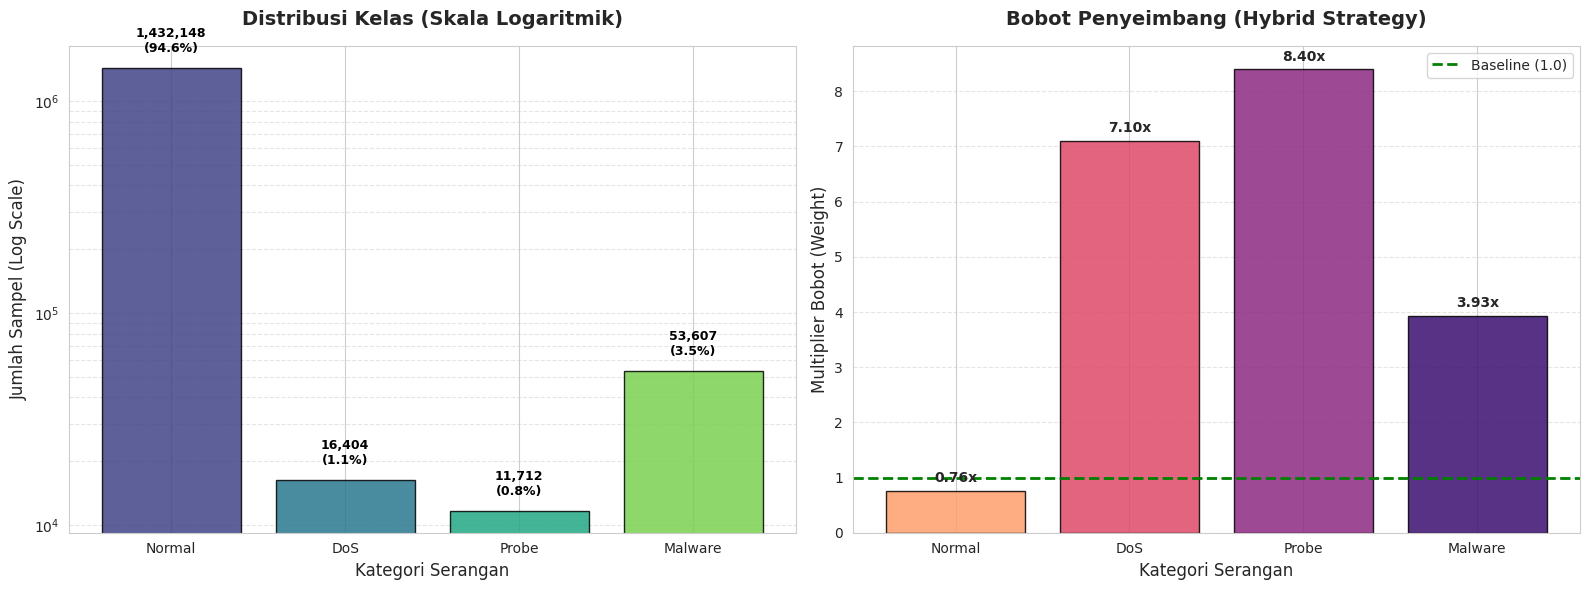

✅ Gambar 1 disimpan: 'distribusi_dan_bobot_skripsi.png'

📊 Membuat visualisasi 'Effective Samples'...


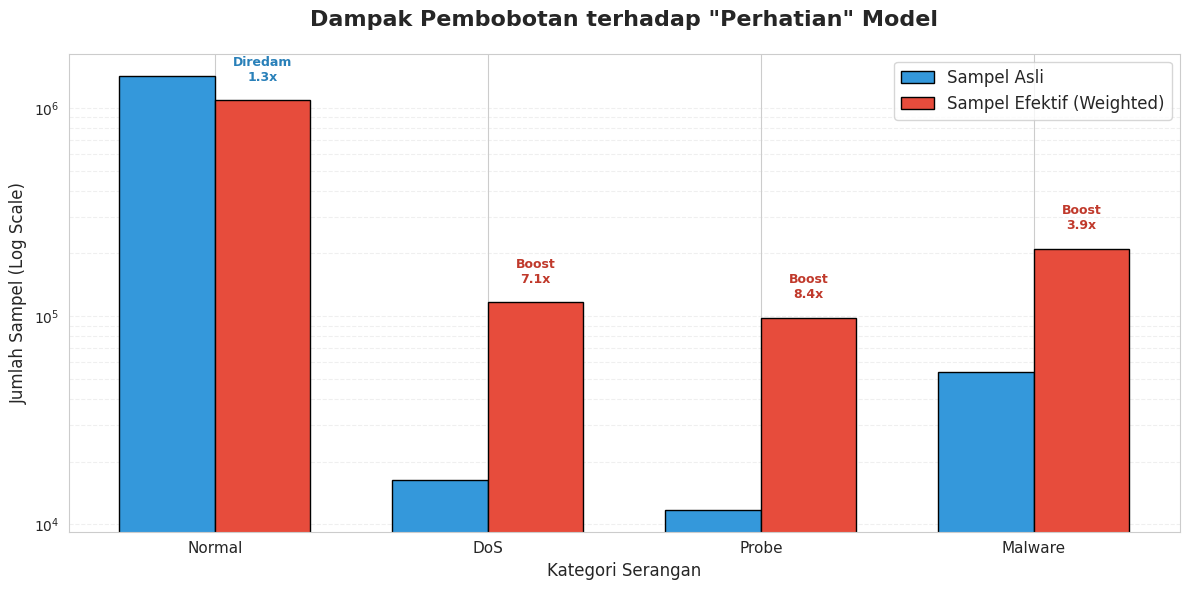

✅ Gambar 2 disimpan: 'impact_weighting_skripsi.png'

✅ Data tabel diekspor ke 'tabel_distribusi_bobot.csv' untuk lampiran skripsi.


In [4]:
# ================================================================================
# Cell 4: Visualisasi Imbalance & Strategi Cost-Sensitive Learning (FINAL)
# ================================================================================
# ⚠️ JALANKAN CELL INI SETELAH CELL 3 (PREPROCESSING) SELESAI!
# ================================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_sample_weight

print("=" * 80)
print("📊 VISUALISASI DISTRIBUSI DATA & STRATEGI PENANGANAN IMBALANCE")
print("=" * 80)
print()

# ================================================================================
# BAGIAN 1: PERSIAPAN DATA & MAPPING LABEL
# ================================================================================

# 1. Definisi Mapping Nama Kelas (Agar grafik terbaca manusia, bukan angka)
# Sesuai Cell 2: 0=Normal, 1=DoS, 2=Probe, 3=Malware
label_map = {0: 'Normal', 1: 'DoS', 2: 'Probe', 3: 'Malware'}

# 2. Hitung jumlah sampel per kelas di Training Set
class_counts_series = pd.Series(y_train).value_counts().sort_index()
unique_classes = class_counts_series.index.tolist() # [0, 1, 2, 3]
class_names_str = [label_map.get(i, str(i)) for i in unique_classes]

print("🔹 Distribusi Kelas di Training Set:")
print(f"   Total samples: {len(y_train):,}")
print(f"   Total classes: {len(unique_classes)}")
print()

# 3. Ambil bobot unik yang sudah dihitung di Cell 3
# Kita ambil satu sampel bobot dari setiap kelas untuk representasi
final_weights = []
raw_weights_calc = compute_sample_weight('balanced', y=y_train) # Hitung ulang raw untuk perbandingan
raw_weights_list = []

for label_id in unique_classes:
    # Cari indeks pertama yang memiliki label ini
    idx = np.where(y_train == label_id)[0][0]
    
    # Ambil bobot final (Hybrid) dari array sample_weights_train
    final_weights.append(sample_weights_train[idx])
    
    # Ambil bobot raw (Balanced standard)
    raw_weights_list.append(raw_weights_calc[idx])

# 4. Buat DataFrame Ringkasan
stats_df = pd.DataFrame({
    'ID_Kelas': unique_classes,
    'Nama_Kelas': class_names_str,
    'Jumlah_Sampel': class_counts_series.values,
    'Persentase': (class_counts_series.values / len(y_train) * 100),
    'Bobot_Raw': raw_weights_list,
    'Bobot_Final_Hybrid': final_weights
})

# Hitung Effective Samples (Jumlah * Bobot)
stats_df['Efektif_Sampel'] = stats_df['Jumlah_Sampel'] * stats_df['Bobot_Final_Hybrid']
stats_df['Imbalance_Ratio'] = stats_df['Jumlah_Sampel'].max() / stats_df['Jumlah_Sampel']

print("   Tabel Statistik Imbalance & Bobot:")
# Format tampilan agar rapi
display_cols = ['Nama_Kelas', 'Jumlah_Sampel', 'Persentase', 'Bobot_Raw', 'Bobot_Final_Hybrid', 'Efektif_Sampel']
print(stats_df[display_cols].to_string(index=False, float_format="%.4f"))
print()

# Statistik Tambahan
majority_class = stats_df.loc[stats_df['Jumlah_Sampel'].idxmax()]
minority_class = stats_df.loc[stats_df['Jumlah_Sampel'].idxmin()]

print("🔹 Highlight Statistik:")
print(f"   - Kelas Mayoritas: {majority_class['Nama_Kelas']} ({majority_class['Jumlah_Sampel']:,} samples)")
print(f"   - Kelas Minoritas: {minority_class['Nama_Kelas']} ({minority_class['Jumlah_Sampel']:,} samples)")
print(f"   - Rasio Imbalance: {majority_class['Jumlah_Sampel'] / minority_class['Jumlah_Sampel']:.2f} : 1")
print(f"   - Bobot Tertinggi: {stats_df['Bobot_Final_Hybrid'].max():.4f} (pada {minority_class['Nama_Kelas']})")

# ================================================================================
# BAGIAN 2: VISUALISASI UTAMA (INPUT UNTUK GAMBAR SKRIPSI)
# ================================================================================

print("\n📊 Membuat visualisasi untuk Bab 3...")
sns.set_style("whitegrid") # Style bersih untuk akademis

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- PLOT A: Distribusi Jumlah Sampel (Log Scale) ---
colors_dist = sns.color_palette("viridis", len(unique_classes))
bars1 = axes[0].bar(
    stats_df['Nama_Kelas'],
    stats_df['Jumlah_Sampel'],
    color=colors_dist,
    edgecolor='black',
    alpha=0.85
)

axes[0].set_title("Distribusi Kelas (Skala Logaritmik)", fontsize=14, fontweight='bold', pad=15)
axes[0].set_yscale("log") # PENTING: Log scale agar minoritas terlihat
axes[0].set_ylabel("Jumlah Sampel (Log Scale)", fontsize=12)
axes[0].set_xlabel("Kategori Serangan", fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.5, which='both')

# Anotasi nilai di atas bar
for bar, count, pct in zip(bars1, stats_df['Jumlah_Sampel'], stats_df['Persentase']):
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width()/2., 
        height * 1.15, 
        f'{count:,}\n({pct:.1f}%)',
        ha='center', va='bottom', fontsize=9, fontweight='bold', color='black'
    )

# --- PLOT B: Bobot Penyeimbang (Hybrid) ---
colors_weight = sns.color_palette("magma_r", len(unique_classes)) # Magma reverse agar bobot tinggi warnanya gelap
bars2 = axes[1].bar(
    stats_df['Nama_Kelas'],
    stats_df['Bobot_Final_Hybrid'],
    color=colors_weight,
    edgecolor='black',
    alpha=0.85
)

axes[1].set_title("Bobot Penyeimbang (Hybrid Strategy)", fontsize=14, fontweight='bold', pad=15)
axes[1].set_ylabel("Multiplier Bobot (Weight)", fontsize=12)
axes[1].set_xlabel("Kategori Serangan", fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# Garis referensi Mean=1.0
axes[1].axhline(y=1.0, color='green', linestyle='--', linewidth=2, label='Baseline (1.0)')

# Anotasi nilai bobot
for bar, weight in zip(bars2, stats_df['Bobot_Final_Hybrid']):
    axes[1].text(
        bar.get_x() + bar.get_width()/2., 
        bar.get_height() + 0.1, 
        f'{weight:.2f}x',
        ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

axes[1].legend()

plt.tight_layout()
plt.savefig('distribusi_dan_bobot_skripsi.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Gambar 1 disimpan: 'distribusi_dan_bobot_skripsi.png'")

# ================================================================================
# BAGIAN 3: VISUALISASI EFEK PEMBOBOTAN (BEFORE VS AFTER)
# ================================================================================

print("\n📊 Membuat visualisasi 'Effective Samples'...")

fig2, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(unique_classes))
width = 0.35

# Bar Original
rects1 = ax.bar(x - width/2, stats_df['Jumlah_Sampel'], width, label='Sampel Asli', color='#3498db', edgecolor='black')
# Bar Weighted
rects2 = ax.bar(x + width/2, stats_df['Efektif_Sampel'], width, label='Sampel Efektif (Weighted)', color='#e74c3c', edgecolor='black')

ax.set_title('Dampak Pembobotan terhadap "Perhatian" Model', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Jumlah Sampel (Log Scale)', fontsize=12)
ax.set_xlabel('Kategori Serangan', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(stats_df['Nama_Kelas'], fontsize=11)
ax.set_yscale('log') # Log scale lagi agar perbandingannya terlihat adil
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.3, which='both')

# Anotasi Kenaikan
for i, (orig, eff) in enumerate(zip(stats_df['Jumlah_Sampel'], stats_df['Efektif_Sampel'])):
    if eff > orig:
        boost = eff / orig
        ax.text(x[i] + width/2, eff * 1.2, f'Boost\n{boost:.1f}x', ha='center', va='bottom', fontsize=9, color='#c0392b', fontweight='bold')
    else:
        shrink = orig / eff
        ax.text(x[i] + width/2, eff * 1.2, f'Diredam\n{shrink:.1f}x', ha='center', va='bottom', fontsize=9, color='#2980b9', fontweight='bold')

plt.tight_layout()
plt.savefig('impact_weighting_skripsi.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Gambar 2 disimpan: 'impact_weighting_skripsi.png'")

# ================================================================================
# BAGIAN 4: EXPORT DATA UNTUK LAMPIRAN
# ================================================================================
stats_df.to_csv('tabel_distribusi_bobot.csv', index=False)
print("\n✅ Data tabel diekspor ke 'tabel_distribusi_bobot.csv' untuk lampiran skripsi.")

# Definisi Objective Function (Generic)

In [5]:
# ================================================================================
# Cell 4: Objective Function Multi-Objective (Macro F1 vs Latency) - FIXED
# ================================================================================

import time
import gc
import xgboost as xgb
import optuna
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

print("="*80)
print("🎯 DEFINISI OBJECTIVE FUNCTION UNTUK OPTUNA")
print("="*80)
print()

# ================================================================================
# KONFIGURASI GLOBAL
# ================================================================================

# Pastikan variabel ini ada dari cell sebelumnya
NUM_CLASSES = len(le_target.classes_)
CLASS_NAMES = le_target.classes_

print("🔹 Konfigurasi Objective Function:")
print(f"   - Target 1:            Maximize Macro F1-Score")
print(f"   - Target 2:            Minimize Latency (µs/sample)")
print(f"   - Jumlah kelas:        {NUM_CLASSES}")
print(f"   - Device:              cuda (GPU)")
print(f"   - Tree method:         hist")
print(f"   - Sample weighting:    Enabled (Hybrid Strategy)")
print()

# ================================================================================
# OBJECTIVE FUNCTION
# ================================================================================

def objective_xgboost_multi(trial):
    """
    Multi-objective function untuk Optuna. 
    
    Returns:
        tuple: (f1_macro, latency_us)
            - f1_macro: Macro F1-Score (TO MAXIMIZE)
            - latency_us: Waktu inferensi per sampel dalam mikrodetik (TO MINIMIZE)
    """
    
    try:
        # ========================================================================
        # BAGIAN 1: HYPERPARAMETER SAMPLING
        # ========================================================================
        
        param = {
            # --- Booster Parameters ---
            # Menggunakan range yang luas untuk eksplorasi
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000, step=100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            
            # --- Tree Structure Parameters ---
            'max_depth': trial.suggest_int('max_depth', 6, 12),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
            'max_delta_step': trial.suggest_int('max_delta_step', 1, 8), # Penting utk imbalance
            
            # --- Regularization & Sampling ---
            'gamma': trial.suggest_float('gamma', 0.1, 0.5),
            'subsample': trial.suggest_float('subsample', 0.6, 0.95),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1.0, log=True),
            
            # --- Fixed Parameters (GPU & Multiclass) ---
            'objective': 'multi:softmax',   # Multiclass classification
            'num_class': NUM_CLASSES,       # Jumlah kelas target
            'tree_method': 'hist',          # Histogram-based (optimal untuk GPU)
            'device': 'cuda',               # GPU acceleration
            'eval_metric': 'mlogloss',      # Metric evaluasi internal
            'verbosity': 0,                 # Suppress XGBoost warnings
            'random_state': 42              # Reproducibility
        }
        
        # ========================================================================
        # BAGIAN 2: MODEL INITIALIZATION & TRAINING
        # ========================================================================
        
        model = xgb.XGBClassifier(**param)
        
        # Training dengan sample weights
        model.fit(
            X_train, y_train,
            sample_weight=sample_weights_train,  # Bobot dari Cell 3
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
        # ========================================================================
        # BAGIAN 3: OBJECTIVE 2 - LATENCY (MINIMIZE)
        # ========================================================================
        # Kita ukur waktu dulu agar cache GPU 'hangat'
        
        # Warm-up (opsional, tapi baik untuk akurasi timer)
        _ = model.predict(X_val.iloc[:100])
        
        # Pengukuran Waktu Presisi
        start_time = time.perf_counter()
        preds = model.predict(X_val) # Prediksi sekalian diambil untuk F1 score
        end_time = time.perf_counter()
        
        total_time = end_time - start_time
        # Konversi ke mikrodetik per sampel (µs/sample)
        # 1 detik = 1,000,000 mikrodetik
        latency_us = (total_time / len(X_val)) * 1_000_000
        
        # Validasi waktu
        if latency_us <= 0:
            raise ValueError(f"Latency invalid: {latency_us}")
            
        # ========================================================================
        # BAGIAN 4: OBJECTIVE 1 - MACRO F1-SCORE (MAXIMIZE)
        # ========================================================================
        
        f1_macro = f1_score(y_val, preds, average='macro')
        
        # Validasi score
        if not (0 <= f1_macro <= 1):
            raise ValueError(f"F1 invalid: {f1_macro}")
            
        # ========================================================================
        # BAGIAN 5: LOGGING & USER ATTRS
        # ========================================================================
        
        accuracy = accuracy_score(y_val, preds)
        
        # Simpan atribut tambahan untuk analisis nanti
        trial.set_user_attr('accuracy', accuracy)
        trial.set_user_attr('total_time_sec', total_time)
        
        # Log progress sederhana
        if trial.number % 10 == 0:
            print(f"   Trial {trial.number:3d}: F1={f1_macro:.4f}, Latency={latency_us:.2f}µs, Acc={accuracy:.4f}")
            
        return f1_macro, latency_us
    
    except Exception as e:
        print(f"   ⚠️ Trial {trial.number} FAILED: {str(e)}")
        # Bersihkan memori jika fail
        gc.collect()
        # Return worst possible values: F1=0 (min), Latency=99999 (max)
        return 0.0, 99999.0

# ================================================================================
# VALIDASI (DRY RUN)
# ================================================================================

print("🔬 Melakukan validasi objective function (dry run)...")

# Dummy study
dummy_study = optuna.create_study(
    directions=['maximize', 'minimize'], 
    sampler=optuna.samplers.RandomSampler(seed=42)
)

try:
    # Jalankan 1 trial
    dummy_study.optimize(objective_xgboost_multi, n_trials=1, show_progress_bar=False)
    
    trial_res = dummy_study.trials[0]
    f1_test, lat_test = trial_res.values
    
    print(f"\n✅ Validasi SUKSES!")
    print(f"   - F1-Score:       {f1_test:.4f}")
    print(f"   - Latency:        {lat_test:.2f} µs/sample")
    print(f"   - Accuracy:       {trial_res.user_attrs.get('accuracy'):.4f}")
    
    del dummy_study
    gc.collect()
    
except Exception as e:
    print(f"\n❌ Validasi GAGAL: {str(e)}")
    raise

# ================================================================================
# INFO SEARCH SPACE
# ================================================================================
print("\n" + "="*80)
print("📋 PARAMETER SEARCH SPACE (SESUAI SKRIPSI & KODE)")
print("="*80)
print(f"{'Parameter':<20} {'Tipe':<17} {'Range':<15} {'Fungsi'}")
print("-" * 80)

# Daftar parameter sesuai definisi di objective_xgboost_multi
params_info = [
    ("n_estimators",     "int",           "[500, 2000]",   "Kompleksitas Model"),
    ("learning_rate",    "float (log)",   "[0.01, 0.3]",   "Kecepatan Konvergensi"),
    ("max_depth",        "int",           "[6, 12]",       "Kapasitas Menangkap Pola"),
    ("min_child_weight", "int",           "[1, 7]",        "Bobot Min. Percabangan"),
    ("max_delta_step",   "int",           "[1, 8]",        "Stabilisasi Imbalance"),
    ("gamma",            "float",         "[0.1, 0.5]",    "Regularisasi Split"),
    ("subsample",        "float",         "[0.6, 0.95]",   "Sampling Baris Data"),
    ("colsample_bytree", "float",         "[0.5, 0.9]",    "Sampling Kolom Fitur"),
    ("reg_alpha (L1)",   "float (log)",   "[1e-6, 1.0]",   "Feature Selection Soft"),
    ("reg_lambda (L2)",  "float (log)",   "[1e-6, 1.0]",   "Mencegah Overfitting")
]

for p_name, p_type, p_range, p_desc in params_info:
    print(f"{p_name:<20} {p_type:<17} {p_range:<15} {p_desc}")

print("-" * 80)
print("✅ Fungsi siap digunakan untuk optimasi NSGA-II, TPE, dan Random.")

[I 2026-02-06 12:45:11,745] A new study created in memory with name: no-name-169adb6c-afbd-4079-a4b4-ab2d37a6feb7


🎯 DEFINISI OBJECTIVE FUNCTION UNTUK OPTUNA

🔹 Konfigurasi Objective Function:
   - Target 1:            Maximize Macro F1-Score
   - Target 2:            Minimize Latency (µs/sample)
   - Jumlah kelas:        4
   - Device:              cuda (GPU)
   - Tree method:         hist
   - Sample weighting:    Enabled (Hybrid Strategy)

🔬 Melakukan validasi objective function (dry run)...


[I 2026-02-06 12:46:38,103] Trial 0 finished with values: [0.8505399495907972, 3.0307563704197986] and parameters: {'n_estimators': 1000, 'learning_rate': 0.2536999076681772, 'max_depth': 11, 'min_child_weight': 5, 'max_delta_step': 2, 'gamma': 0.16239780813448107, 'subsample': 0.6203292642588698, 'colsample_bytree': 0.846470458309974, 'reg_alpha': 0.004042872735027332, 'reg_lambda': 0.017718847354806822}. 


   Trial   0: F1=0.8505, Latency=3.03µs, Acc=0.9921

✅ Validasi SUKSES!
   - F1-Score:       0.8505
   - Latency:        3.03 µs/sample
   - Accuracy:       0.9921

📋 PARAMETER SEARCH SPACE (SESUAI SKRIPSI & KODE)
Parameter            Tipe              Range           Fungsi
--------------------------------------------------------------------------------
n_estimators         int               [500, 2000]     Kompleksitas Model
learning_rate        float (log)       [0.01, 0.3]     Kecepatan Konvergensi
max_depth            int               [6, 12]         Kapasitas Menangkap Pola
min_child_weight     int               [1, 7]          Bobot Min. Percabangan
max_delta_step       int               [1, 8]          Stabilisasi Imbalance
gamma                float             [0.1, 0.5]      Regularisasi Split
subsample            float             [0.6, 0.95]     Sampling Baris Data
colsample_bytree     float             [0.5, 0.9]      Sampling Kolom Fitur
reg_alpha (L1)       float (log)

# 3 Strategi - Optuna TPE (Tree-structured Parzen Estimator), Optuna NSGA-II (Genetic Algorithm), Optuna RandomSampler (Baseline)

In [6]:
# ================================================================================
# Cell 5.0: Import & Konfigurasi Optimasi (UPGRADED)
# ================================================================================

import optuna
from optuna.samplers import TPESampler, NSGAIISampler, RandomSampler
import time
import pandas as pd
import warnings

# Suppress experimental warnings dari Optuna
warnings.filterwarnings('ignore', category=optuna.exceptions.ExperimentalWarning)

print("=" * 80)
print("🚀 OPTIMASI HYPERPARAMETER MULTI-OBJECTIVE")
print("=" * 80)
print()

# ================================================================================
# KONFIGURASI EKSPERIMEN (SESUAIKAN DENGAN KUOTA GPU)
# ================================================================================

# Saran Skripsi: 50 trials agar Pareto Front terlihat jelas. 
# Jika GPU terbatas, kembalikan ke 30.
N_TRIALS = 30
SEED = 42

# Definisi Arah Optimasi (PENTING AGAR KONSISTEN)
# Objective 1: F1-Score -> Maximize
# Objective 2: Latency  -> Minimize
STUDY_DIRECTIONS = ['maximize', 'minimize']

print("🔹 Konfigurasi Optimasi:")
print(f"   - Jumlah trials per metode: {N_TRIALS}")
print(f"   - Metode yang diuji:        NSGA-II, TPE, Random Sampler")
print(f"   - Total evaluasi model:     {N_TRIALS * 3} kali training")
print(f"   - Objectives:               1. Maximize F1-Macro")
print(f"                               2. Minimize Inference Time")
print(f"   - Random seed:              {SEED}")

# Estimasi Waktu (Kasar)
print("\n⚠️  ESTIMASI WAKTU:")
print("   Jika 1 trial memakan waktu ±30-60 detik:")
print(f"   Total waktu tunggu sekitar: {(N_TRIALS * 3 * 45) / 60:.0f} - {(N_TRIALS * 3 * 60) / 60:.0f} menit.")

🚀 OPTIMASI HYPERPARAMETER MULTI-OBJECTIVE

🔹 Konfigurasi Optimasi:
   - Jumlah trials per metode: 30
   - Metode yang diuji:        NSGA-II, TPE, Random Sampler
   - Total evaluasi model:     90 kali training
   - Objectives:               1. Maximize F1-Macro
                               2. Minimize Inference Time
   - Random seed:              42

⚠️  ESTIMASI WAKTU:
   Jika 1 trial memakan waktu ±30-60 detik:
   Total waktu tunggu sekitar: 68 - 90 menit.


In [7]:
# ================================================================================
# Cell 5.1: Container Hasil Optimasi
# ================================================================================

optimization_results = {}


In [8]:
# ================================================================================
# Cell 5.2: TPE (Bayesian Optimization)
# ================================================================================

print("=" * 80)
print("🚀 [1/3] TPE (BAYESIAN OPTIMIZATION)")
print("=" * 80)
print()

start_tpe = time.time()

study_tpe = optuna.create_study(
    study_name="TPE_MultiObjective",
    directions=["maximize", "minimize"],
    sampler=TPESampler(seed=SEED)
)

print(f"⏳ Menjalankan {N_TRIALS} trials...")

try:
    study_tpe.optimize(
        objective_xgboost_multi,
        n_trials=N_TRIALS,
        show_progress_bar=True,
        n_jobs=1
    )

    time_tpe = time.time() - start_tpe

    print(f"\n✅ TPE selesai dalam {time_tpe:.2f} detik")
    print(f"   - Trials completed:        {len(study_tpe.trials)}")
    print(f"   - Pareto optimal trials:   {len(study_tpe.best_trials)}")

    optimization_results["TPE"] = {
        "study": study_tpe,
        "time": time_tpe,
        "n_pareto": len(study_tpe.best_trials)
    }

except Exception as e:
    print(f"\n❌ TPE gagal: {e}")
    optimization_results["TPE"] = {"study": None, "time": 0, "n_pareto": 0}
 

[I 2026-02-06 12:46:38,336] A new study created in memory with name: TPE_MultiObjective


🚀 [1/3] TPE (BAYESIAN OPTIMIZATION)

⏳ Menjalankan 30 trials...


  0%|          | 0/30 [00:00<?, ?it/s]

   Trial   0: F1=0.8505, Latency=3.07µs, Acc=0.9921
[I 2026-02-06 12:48:04,703] Trial 0 finished with values: [0.8505399495907972, 3.0741545652471363] and parameters: {'n_estimators': 1000, 'learning_rate': 0.2536999076681772, 'max_depth': 11, 'min_child_weight': 5, 'max_delta_step': 2, 'gamma': 0.16239780813448107, 'subsample': 0.6203292642588698, 'colsample_bytree': 0.846470458309974, 'reg_alpha': 0.004042872735027332, 'reg_lambda': 0.017718847354806822}. 
[I 2026-02-06 12:48:50,880] Trial 1 finished with values: [0.8551861219041459, 1.9681638976081097] and parameters: {'n_estimators': 500, 'learning_rate': 0.2708160864249968, 'max_depth': 11, 'min_child_weight': 2, 'max_delta_step': 2, 'gamma': 0.17336180394137352, 'subsample': 0.7064847850358382, 'colsample_bytree': 0.7099025726528951, 'reg_alpha': 0.0003905441275210792, 'reg_lambda': 5.589524205217924e-05}. 
[I 2026-02-06 12:50:33,220] Trial 2 finished with values: [0.8630831287949157, 4.148372142426782] and parameters: {'n_estima

In [9]:
# ================================================================================
# Cell 5.3: NSGA-II (Evolutionary Algorithm)
# ================================================================================

print("=" * 80)
print("🚀 [2/3] NSGA-II (EVOLUTIONARY ALGORITHM)")
print("=" * 80)
print()

start_nsga = time.time()

study_nsga = optuna.create_study(
    study_name="NSGAII_MultiObjective",
    directions=["maximize", "minimize"],
    sampler=NSGAIISampler(seed=SEED, population_size=10)
)

print(f"⏳ Menjalankan {N_TRIALS} trials...")

try:
    study_nsga.optimize(
        objective_xgboost_multi,
        n_trials=N_TRIALS,
        show_progress_bar=True,
        n_jobs=1
    )

    time_nsga = time.time() - start_nsga

    print(f"\n✅ NSGA-II selesai dalam {time_nsga:.2f} detik")
    print(f"   - Trials completed:        {len(study_nsga.trials)}")
    print(f"   - Pareto optimal trials:   {len(study_nsga.best_trials)}")

    optimization_results["NSGA-II"] = {
        "study": study_nsga,
        "time": time_nsga,
        "n_pareto": len(study_nsga.best_trials)
    }

except Exception as e:
    print(f"\n❌ NSGA-II gagal: {e}")
    optimization_results["NSGA-II"] = {"study": None, "time": 0, "n_pareto": 0}


[I 2026-02-06 13:21:17,351] A new study created in memory with name: NSGAII_MultiObjective


🚀 [2/3] NSGA-II (EVOLUTIONARY ALGORITHM)

⏳ Menjalankan 30 trials...


  0%|          | 0/30 [00:00<?, ?it/s]

   Trial   0: F1=0.8505, Latency=3.04µs, Acc=0.9921
[I 2026-02-06 13:22:42,829] Trial 0 finished with values: [0.8505399495907972, 3.0448641417507734] and parameters: {'n_estimators': 1000, 'learning_rate': 0.2536999076681772, 'max_depth': 11, 'min_child_weight': 5, 'max_delta_step': 2, 'gamma': 0.16239780813448107, 'subsample': 0.6203292642588698, 'colsample_bytree': 0.846470458309974, 'reg_alpha': 0.004042872735027332, 'reg_lambda': 0.017718847354806822}. 
[I 2026-02-06 13:23:28,607] Trial 1 finished with values: [0.8551861219041459, 1.9757481266579089] and parameters: {'n_estimators': 500, 'learning_rate': 0.2708160864249968, 'max_depth': 11, 'min_child_weight': 2, 'max_delta_step': 2, 'gamma': 0.17336180394137352, 'subsample': 0.7064847850358382, 'colsample_bytree': 0.7099025726528951, 'reg_alpha': 0.0003905441275210792, 'reg_lambda': 5.589524205217924e-05}. 
[I 2026-02-06 13:25:10,032] Trial 2 finished with values: [0.8630831287949157, 4.098736780916697] and parameters: {'n_estima

In [10]:
# ================================================================================
# Cell 5.4: Random Sampler (Baseline)
# ================================================================================

print("=" * 80)
print("🚀 [3/3] RANDOM SAMPLER (BASELINE)")
print("=" * 80)
print()

start_random = time.time()

study_random = optuna.create_study(
    study_name="Random_MultiObjective",
    directions=["maximize", "minimize"],
    sampler=RandomSampler(seed=SEED)
)

print(f"⏳ Menjalankan {N_TRIALS} trials...")

try:
    study_random.optimize(
        objective_xgboost_multi,
        n_trials=N_TRIALS,
        show_progress_bar=True,
        n_jobs=1
    )

    time_random = time.time() - start_random

    print(f"\n✅ Random selesai dalam {time_random:.2f} detik")
    print(f"   - Trials completed:        {len(study_random.trials)}")
    print(f"   - Pareto optimal trials:   {len(study_random.best_trials)}")

    optimization_results["Random"] = {
        "study": study_random,
        "time": time_random,
        "n_pareto": len(study_random.best_trials)
    }

except Exception as e:
    print(f"\n❌ Random gagal: {e}")
    optimization_results["Random"] = {"study": None, "time": 0, "n_pareto": 0}
    

[I 2026-02-06 14:04:35,269] A new study created in memory with name: Random_MultiObjective


🚀 [3/3] RANDOM SAMPLER (BASELINE)

⏳ Menjalankan 30 trials...


  0%|          | 0/30 [00:00<?, ?it/s]

   Trial   0: F1=0.8505, Latency=3.05µs, Acc=0.9921
[I 2026-02-06 14:06:01,752] Trial 0 finished with values: [0.8505399495907972, 3.04889789361235] and parameters: {'n_estimators': 1000, 'learning_rate': 0.2536999076681772, 'max_depth': 11, 'min_child_weight': 5, 'max_delta_step': 2, 'gamma': 0.16239780813448107, 'subsample': 0.6203292642588698, 'colsample_bytree': 0.846470458309974, 'reg_alpha': 0.004042872735027332, 'reg_lambda': 0.017718847354806822}. 
[I 2026-02-06 14:06:48,134] Trial 1 finished with values: [0.8551861219041459, 1.9850537403423205] and parameters: {'n_estimators': 500, 'learning_rate': 0.2708160864249968, 'max_depth': 11, 'min_child_weight': 2, 'max_delta_step': 2, 'gamma': 0.17336180394137352, 'subsample': 0.7064847850358382, 'colsample_bytree': 0.7099025726528951, 'reg_alpha': 0.0003905441275210792, 'reg_lambda': 5.589524205217924e-05}. 
[I 2026-02-06 14:08:30,539] Trial 2 finished with values: [0.8630831287949157, 4.183878071593177] and parameters: {'n_estimato

In [11]:
# ================================================================================
# Cell Tambahan: Ekstraksi Parameter Pareto Optimal (ALL METHODS)
# ================================================================================
import pandas as pd

# 1. Konfigurasi Tampilan Pandas (Agar tabel tidak terpotong saat di-screenshot)
pd.set_option('display.max_columns', None)        # Tampilkan semua kolom
pd.set_option('display.max_rows', None)           # Tampilkan semua baris
pd.set_option('display.width', 1000)              # Lebar display maksimal
pd.set_option('display.float_format', '{:.4f}'.format) # Presisi angka desimal

print("=" * 100)
print("📊 REKAPITULASI DETAIL PARAMETER SOLUSI PARETO OPTIMAL (SEMUA METODE)")
print("=" * 100)

# Fungsi bantuan untuk ekstrak data
def extract_pareto_data(study, method_name):
    if study is None:
        return None
    
    best_trials = study.best_trials
    data = []
    for trial in best_trials:
        row = {
            "Trial ID": trial.number,
            "Macro F1": trial.values[0],
            "Latensi (µs)": trial.values[1],
            **trial.params # Unpack semua parameter (learning_rate, max_depth, dll)
        }
        data.append(row)
    
    df = pd.DataFrame(data)
    # Urutkan berdasarkan F1 tertinggi
    if not df.empty:
        df = df.sort_values(by="Macro F1", ascending=False).reset_index(drop=True)
    return df

# ================================================================================
# 1. METODE TPE (Tree-structured Parzen Estimator)
# ================================================================================
print("\n" + "─" * 50)
print("🏆 1. METODE TPE (Bayesian)")
print("─" * 50)

if "TPE" in optimization_results and optimization_results["TPE"]["study"] is not None:
    df_tpe = extract_pareto_data(optimization_results["TPE"]["study"], "TPE")
    print(f"✅ Ditemukan {len(df_tpe)} solusi Pareto.")
    print("\n📋 TABEL KONFIGURASI TPE :")
    print(df_tpe)
    # Simpan
    df_tpe.to_csv("pareto_params_tpe.csv", index=False)
else:
    print("⚠️ Data TPE tidak ditemukan.")

# ================================================================================
# 2. METODE NSGA-II (Evolutionary)
# ================================================================================
print("\n" + "─" * 50)
print("🧬 2. METODE NSGA-II (Evolutionary)")
print("─" * 50)

if "NSGA-II" in optimization_results and optimization_results["NSGA-II"]["study"] is not None:
    df_nsga = extract_pareto_data(optimization_results["NSGA-II"]["study"], "NSGA-II")
    print(f"✅ Ditemukan {len(df_nsga)} solusi Pareto.")
    print("\n📋 TABEL KONFIGURASI NSGA-II :")
    print(df_nsga)
    # Simpan
    df_nsga.to_csv("pareto_params_nsgaii.csv", index=False)
else:
    print("⚠️ Data NSGA-II tidak ditemukan.")

# ================================================================================
# 3. METODE RANDOM SEARCH (Baseline)
# ================================================================================
print("\n" + "─" * 50)
print("🎲 3. METODE RANDOM SEARCH (Baseline)")
print("─" * 50)

# Cek nama key (kadang 'Random' kadang 'RandomSearch')
key_random = "Random" if "Random" in optimization_results else "RandomSearch"

if key_random in optimization_results and optimization_results[key_random]["study"] is not None:
    df_random = extract_pareto_data(optimization_results[key_random]["study"], "Random")
    print(f"✅ Ditemukan {len(df_random)} solusi non-dominated.")
    print("\n📋 TABEL KONFIGURASI RANDOM SEARCH :")
    print(df_random)
    # Simpan
    df_random.to_csv("pareto_params_random.csv", index=False)
else:
    print("⚠️ Data Random Search tidak ditemukan.")

print("\n" + "=" * 100)
print("✅ SELESAI. File CSV juga telah disimpan untuk lampiran.")

📊 REKAPITULASI DETAIL PARAMETER SOLUSI PARETO OPTIMAL (SEMUA METODE)

──────────────────────────────────────────────────
🏆 1. METODE TPE (Bayesian)
──────────────────────────────────────────────────
✅ Ditemukan 7 solusi Pareto.

📋 TABEL KONFIGURASI TPE :
   Trial ID  Macro F1  Latensi (µs)  n_estimators  learning_rate  max_depth  min_child_weight  max_delta_step  gamma  subsample  colsample_bytree  reg_alpha  reg_lambda
0        19    0.8645        2.4395           600         0.0234         10                 3               7 0.2786     0.7338            0.6589     0.0106      0.0000
1        22    0.8634        2.1871           800         0.0748          7                 2               5 0.1355     0.7924            0.8476     0.0631      0.0062
2        13    0.8626        1.9984           700         0.0523          7                 6               1 0.3579     0.7845            0.7670     0.0473      0.0047
3        20    0.8607        1.7313           500         0.0346     

In [12]:
# ================================================================================
# Cell 5.5: Ringkasan Perbandingan Metode
# ================================================================================

print("=" * 80)
print("📊 RINGKASAN PERBANDINGAN METODE")
print("=" * 80)

comparison_data = []

for method, result in optimization_results.items():
    if result["study"] is not None and result["study"].best_trials:
        best_trial = max(result["study"].best_trials, key=lambda t: t.values[0])
        best_f1, best_time = best_trial.values
    else:
        best_f1, best_time = 0.0, 9999.0

    comparison_data.append({
        "Metode": method,
        "Waktu_Optimasi_s": result["time"],
        "Waktu_Optimasi_min": result["time"] / 60,
        "Pareto_Solutions": result["n_pareto"],
        "Best_F1": best_f1,
        "Best_InferenceTime": best_time
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df


📊 RINGKASAN PERBANDINGAN METODE


,Metode,Waktu_Optimasi_s,Waktu_Optimasi_min,Pareto_Solutions,Best_F1,Best_InferenceTime
0,TPE,2078.9986,34.6500,7,0.8645,2.4395
1,NSGA-II,2597.9001,43.2983,4,0.8631,4.0987
2,Random,2916.3038,48.6051,6,0.8660,4.2495


# Evaluasi Model Final & Komparasi

In [13]:
# ================================================================================
# Cell 8: Evaluasi Final (TPE vs NSGA-II vs Random) - FIXED
# ================================================================================

import pandas as pd
import numpy as np
import time
import xgboost as xgb
import gc
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight

print("=" * 80)
print("🏆 EVALUASI FINAL - PERBANDINGAN 3 METODE OPTIMASI")
print("=" * 80)
print()

# Mapping Nama Kelas (Agar Output Rapi)
# Pastikan label_map sudah ada, kalau belum kita definisikan ulang
label_map = {0: 'Normal', 1: 'DoS', 2: 'Probe', 3: 'Malware'}
target_names = [label_map.get(i, str(i)) for i in range(len(label_map))]

# ================================================================================
# 1. HELPER: PILIH SOLUSI TERBAIK DARI PARETO FRONT
# ================================================================================

def get_best_params_strategy(study, name):
    """
    Strategi pemilihan model terbaik:
    - Untuk Single Objective (Random/TPE): Ambil best_trial biasa.
    - Untuk Multi Objective (NSGA-II): Ambil solusi dengan F1-Score Tertinggi 
      (Prioritas Keamanan) dari Pareto Front.
    """
    print(f"🔍 Menganalisis hasil optimasi {name}...")
    
    # Cek apakah study valid
    if len(study.trials) == 0:
        raise ValueError(f"Study {name} kosong!")

    # Logika Pengambilan Best Trial
    if name == "NSGA-II":
        # Multi-objective: study.best_trials mengembalikan list Pareto Front
        pareto_front = study.best_trials
        if not pareto_front:
            # Fallback jika pareto kosong (jarang terjadi)
            best_trial = study.trials[0]
        else:
            # STRATEGI SKRIPSI: Pilih solusi dengan F1 tertinggi (Objective 0)
            # Trade-off: Kita korbankan sedikit waktu demi akurasi maksimal untuk perbandingan ini
            best_trial = max(pareto_front, key=lambda t: t.values[0])
            
        print(f"   ℹ️  NSGA-II: Dipilih solusi Pareto dengan F1 tertinggi dari {len(pareto_front)} kandidat.")
    else:
        # Single objective (atau jika TPE dijadikan multi, logicnya mirip NSGA-II)
        # Jika TPE di-set multi-obj di Cell 5, gunakan logika pareto juga
        if len(study.directions) > 1:
             pareto_front = study.best_trials
             best_trial = max(pareto_front, key=lambda t: t.values[0])
        else:
             best_trial = study.best_trial

    # Ambil Values
    val_f1 = best_trial.values[0]
    val_lat = best_trial.values[1]

    print(f"   ✅ Best Trial ID: #{best_trial.number}")
    print(f"      - Validasi F1:      {val_f1:.4f}")
    print(f"      - Validasi Latency: {val_lat:.2f} µs")

    return best_trial.params

# ================================================================================
# 2. FUNGSI TRAINING ULANG (RETRAIN)
# ================================================================================

def train_and_evaluate(study, name):
    # 1. Ambil Parameter Terbaik
    best_params = get_best_params_strategy(study, name)
    
    # 2. Tambahkan Parameter Tetap (Fixed)
    best_params.update({
        'objective': 'multi:softmax',
        'num_class': len(target_names),
        'tree_method': 'hist',
        'device': 'cuda',
        'eval_metric': 'mlogloss',
        'verbosity': 0,
        'random_state': 42
    })
    
    # 3. Training Ulang
    # Catatan Metodologi: Gunakan X_train dan X_val terpisah untuk mencegah Data Leakage.
    # Jangan digabung (X_full) jika menggunakan eval_set.
    
    print(f"   ⏳ Training ulang model {name} ({best_params['n_estimators']} trees)...")
    
    model = xgb.XGBClassifier(**best_params)
    
    start_train = time.time()
    model.fit(
        X_train, y_train,
        sample_weight=sample_weights_train, # Bobot Hybrid dari Cell 3
        eval_set=[(X_val, y_val)],
        verbose=False # Supress log biar notebook bersih
    )
    train_dur = time.time() - start_train
    print(f"   ✅ Training selesai dalam {train_dur:.2f} detik.")

    # 4. Evaluasi pada TEST SET (Unseen Data)
    print("   ⏱️  Mengukur performa di Test Set...")
    
    # Warm-up GPU
    _ = model.predict(X_test_selected.iloc[:100])
    
    # Ukur Waktu Inferensi Presisi
    start_inf = time.perf_counter()
    preds = model.predict(X_test_selected)
    end_inf = time.perf_counter()
    
    # Hitung Latency (Microseconds per Sample)
    total_inf_time = end_inf - start_inf
    latency_us = (total_inf_time / len(X_test_selected)) * 1_000_000
    
    return model, preds, latency_us, train_dur

# ================================================================================
# 3. EKSEKUSI LOOP EVALUASI
# ================================================================================

results_data = []
trained_models = {}

# List study yang akan dievaluasi (Pastikan variabel study_tpe dll ada dari Cell 7)
studies_map = []
if 'study_nsga' in locals(): studies_map.append(("NSGA-II", study_nsga))
if 'study_tpe' in locals():  studies_map.append(("TPE", study_tpe))
if 'study_random' in locals(): studies_map.append(("Random", study_random))

if not studies_map:
    print("❌ TIDAK ADA STUDY YANG DITEMUKAN. Jalankan Cell 5-7 dulu!")
else:
    for name, study in studies_map:
        print("\n" + "-"*50)
        print(f"🔬 PROSES: {name}")
        print("-"*50)
        
        try:
            # Jalankan Training & Evaluasi
            model, preds, latency, train_time = train_and_evaluate(study, name)
            
            # Simpan Model Global
            trained_models[name] = model
            
            # Hitung Metrik Akurasi Final
            acc = accuracy_score(y_test_final, preds)
            f1 = f1_score(y_test_final, preds, average='macro')
            
            # Simpan Hasil
            results_data.append({
                'Metode': name,
                'F1_Macro': f1,
                'Accuracy': acc,
                'Latency (µs)': latency,
                'Training Time (s)': train_time,
                'Best Params': str(model.get_params()['n_estimators']) + " trees" # Contoh ringkasan
            })
            
            # Cetak Laporan Singkat
            print(f"\n📄 Laporan Klasifikasi ({name}):")
            print(classification_report(y_test_final, preds, target_names=target_names, digits=4))
            
            # Opsional: Confusion Matrix text
            # cm = confusion_matrix(y_test_final, preds)
            # print(f"Confusion Matrix:\n{cm}")

        except Exception as e:
            print(f"❌ Gagal mengevaluasi {name}: {str(e)}")
            import traceback
            traceback.print_exc()

# ================================================================================
# 4. REKAPITULASI HASIL (OUTPUT TABEL SKRIPSI)
# ================================================================================

if results_data:
    print("\n" + "="*80)
    print("🏆 REKAPITULASI HASIL AKHIR (TEST SET)")
    print("="*80)
    
    df_results = pd.DataFrame(results_data)
    df_results = df_results.set_index('Metode')
    
    # Format tampilan
    print(df_results[['F1_Macro', 'Accuracy', 'Latency (µs)', 'Training Time (s)']].to_string(float_format="%.4f"))
    
    # Cari Pemenang
    best_f1_method = df_results['F1_Macro'].idxmax()
    best_lat_method = df_results['Latency (µs)'].idxmin()
    
    print("\n✅ KESIMPULAN:")
    print(f"   - Juara Akurasi (F1):  {best_f1_method} ({df_results.loc[best_f1_method, 'F1_Macro']:.4f})")
    print(f"   - Juara Kecepatan:     {best_lat_method} ({df_results.loc[best_lat_method, 'Latency (µs)']:.2f} µs)")
    
    # Simpan CSV
    df_results.to_csv('tabel_perbandingan_metode.csv')
    print("\n💾 Tabel disimpan ke 'tabel_perbandingan_metode.csv'")
    
    # Clean memory GPU
    del model
    gc.collect()

🏆 EVALUASI FINAL - PERBANDINGAN 3 METODE OPTIMASI


--------------------------------------------------
🔬 PROSES: NSGA-II
--------------------------------------------------
🔍 Menganalisis hasil optimasi NSGA-II...
   ℹ️  NSGA-II: Dipilih solusi Pareto dengan F1 tertinggi dari 4 kandidat.
   ✅ Best Trial ID: #2
      - Validasi F1:      0.8631
      - Validasi Latency: 4.10 µs
   ⏳ Training ulang model NSGA-II (1400 trees)...
   ✅ Training selesai dalam 100.42 detik.
   ⏱️  Mengukur performa di Test Set...

📄 Laporan Klasifikasi (NSGA-II):
              precision    recall  f1-score   support

      Normal     1.0000    1.0000    1.0000    447546
         DoS     0.8831    0.7563    0.8148      5126
       Probe     0.7301    0.7257    0.7279      3660
     Malware     0.8834    0.9235    0.9030     16753

    accuracy                         0.9925    473085
   macro avg     0.8742    0.8514    0.8614    473085
weighted avg     0.9925    0.9925    0.9925    473085


--------------------

# Visualisasi A : Pareto Front Gabungan

📊 VISUALISASI PARETO FRONT (STATIC) - PERBANDINGAN METODE OPTIMASI
ℹ️  Ukuran Validation Set: 378,468 sampel (untuk kalkulasi Latency)

✅ Gambar berhasil disimpan sebagai: pareto_front_static_hd.png


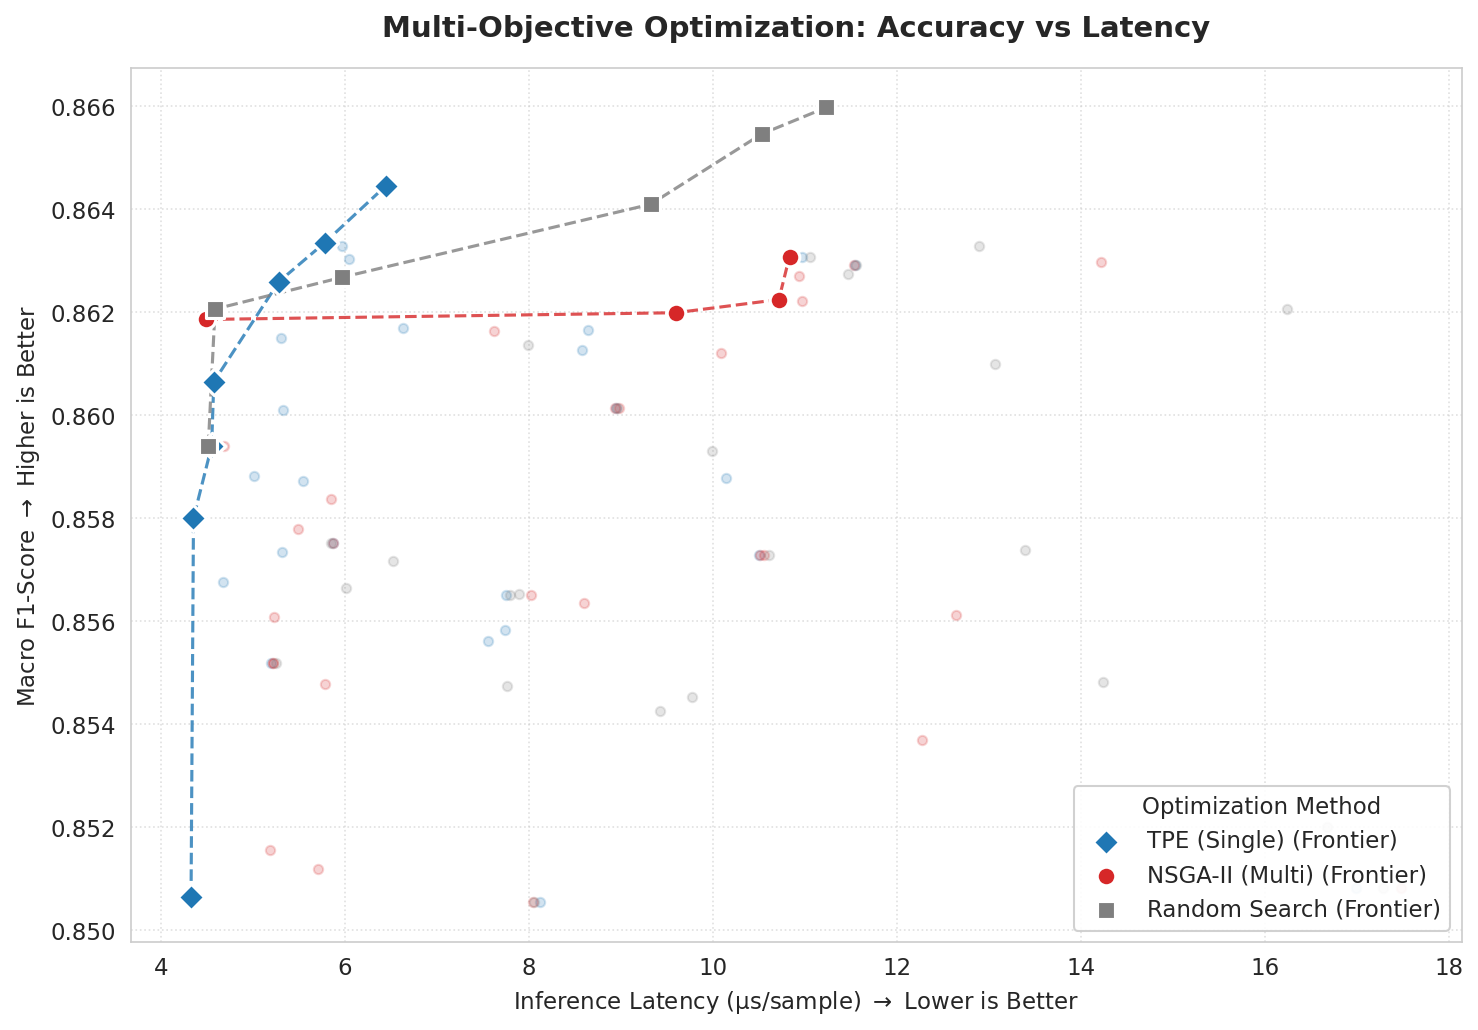


📋 CARA MEMBACA GRAFIK INI:
1. Titik-titik transparan kecil adalah percobaan yang gagal/kurang optimal.
2. Titik-titik BESAR yang terhubung garis putus-putus adalah SOLUSI TERBAIK (Pareto Front).
3. Metode terbaik adalah yang garisnya paling mendekati pojok KIRI ATAS.
   (Artinya: Latency rendah/kiri DAN F1-Score tinggi/atas).
4. Bandingkan garis Merah (NSGA-II) vs Biru (TPE).
   - Jika Merah lebih ke kiri-atas dari Biru -> NSGA-II menang.


In [14]:
# ================================================================================
# Cell 9: Visualisasi Pareto Front (Static / Publication Ready) - Matplotlib
# ================================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import pandas as pd
import numpy as np

# Set style agar terlihat profesional (seperti jurnal)
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 11})

print("="*80)
print("📊 VISUALISASI PARETO FRONT (STATIC) - PERBANDINGAN METODE OPTIMASI")
print("="*80)

# ================================================================================
# 1. KONFIGURASI DATA & VALIDASI
# ================================================================================

# Validasi X_val untuk konversi waktu
try:
    VAL_SIZE = len(X_val)
    print(f"ℹ️  Ukuran Validation Set: {VAL_SIZE:,} sampel (untuk kalkulasi Latency)")
except NameError:
    # Fallback dummy jika X_val tidak ada (hanya agar kode jalan)
    VAL_SIZE = 1000 
    print("⚠️ X_val tidak ditemukan. Menggunakan nilai dummy 1000.")

available_studies = {}
# Cek ketersediaan studi (pastikan nama variabel sesuai dengan cell sebelumnya)
if 'study_tpe' in locals() and study_tpe: available_studies['TPE (Single)'] = study_tpe
if 'study_nsga' in locals() and study_nsga: available_studies['NSGA-II (Multi)'] = study_nsga
if 'study_random' in locals() and study_random: available_studies['Random Search'] = study_random

if not available_studies:
    raise ValueError("❌ Tidak ada study yang tersedia! Jalankan Cell 5-7 dulu.")

# ================================================================================
# 2. HELPER: EKSTRAKSI DATA
# ================================================================================

def get_study_data_static(study, name):
    data_points = []
    
    # Ambil trial yang sukses
    valid_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    
    # Ambil ID dari Best Trials (Pareto Front)
    # Kita pakai set ID karena object trial tidak bisa di-hash
    pareto_ids = set([t.number for t in study.best_trials])
    
    for t in valid_trials:
        # Asumsi: values[0] = F1 (Maximize), values[1] = Time (Minimize)
        f1 = t.values[0]
        raw_time = t.values[1]
        
        # Konversi ke Microseconds per sample
        latency_us = (raw_time / VAL_SIZE) * 1_000_000
        
        is_pareto = t.number in pareto_ids
        
        data_points.append({
            'Method': name,
            'F1_Score': f1,
            'Latency_us': latency_us,
            'Is_Pareto': is_pareto
        })
    
    return pd.DataFrame(data_points)

# ================================================================================
# 3. PLOTTING (MATPLOTLIB)
# ================================================================================

# Buat Canvas Gambar (Ukuran HD)
plt.figure(figsize=(10, 7), dpi=150) # DPI tinggi agar teks tajam

# Definisi Warna & Marker
colors = {
    'NSGA-II (Multi)': '#d62728',  # Merah (Highlight)
    'TPE (Single)':    '#1f77b4',  # Biru
    'Random Search':   '#7f7f7f'   # Abu-abu
}
markers = {
    'NSGA-II (Multi)': 'o',  # Bulat
    'TPE (Single)':    'D',  # Diamond
    'Random Search':   's'   # Kotak
}

# Loop setiap metode untuk plotting
for name, study in available_studies.items():
    df = get_study_data_static(study, name)
    c = colors.get(name, 'black')
    m = markers.get(name, 'o')
    
    # 1. Plot Titik Eksplorasi (Titik kecil transparan)
    non_pareto = df[~df['Is_Pareto']]
    plt.scatter(
        non_pareto['Latency_us'], 
        non_pareto['F1_Score'], 
        color=c, alpha=0.2, s=20, label=None # Label none agar tidak menuhin legenda
    )
    
    # 2. Plot Pareto Front (Titik besar solid + Garis)
    pareto = df[df['Is_Pareto']].sort_values(by='Latency_us')
    
    if len(pareto) > 0:
        # Gambar Garis Penghubung Pareto
        plt.plot(
            pareto['Latency_us'], 
            pareto['F1_Score'], 
            color=c, linestyle='--', linewidth=1.5, alpha=0.8
        )
        
        # Gambar Titik Pareto
        plt.scatter(
            pareto['Latency_us'], 
            pareto['F1_Score'], 
            color=c, marker=m, s=80, edgecolors='white', linewidth=1.5,
            label=f"{name} (Frontier)", zorder=5
        )

# ================================================================================
# 4. KOSMETIK & PENYIMPANAN
# ================================================================================

plt.title('Multi-Objective Optimization: Accuracy vs Latency', fontsize=14, pad=15, fontweight='bold')
plt.xlabel('Inference Latency (µs/sample) $\\rightarrow$ Lower is Better', fontsize=11)
plt.ylabel('Macro F1-Score $\\rightarrow$ Higher is Better', fontsize=11)

# Tambahkan Legend
plt.legend(title='Optimization Method', loc='lower right', frameon=True, framealpha=0.9)

# Grid & Layout
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()

# Simpan Gambar
filename = 'pareto_front_static_hd.png'
plt.savefig(filename, dpi=300, bbox_inches='tight') # 300 DPI = Kualitas Cetak
print(f"\n✅ Gambar berhasil disimpan sebagai: {filename}")

# Tampilkan di Notebook
plt.show()

# ================================================================================
# 5. INTERPRETASI
# ================================================================================
print("\n📋 CARA MEMBACA GRAFIK INI:")
print("1. Titik-titik transparan kecil adalah percobaan yang gagal/kurang optimal.")
print("2. Titik-titik BESAR yang terhubung garis putus-putus adalah SOLUSI TERBAIK (Pareto Front).")
print("3. Metode terbaik adalah yang garisnya paling mendekati pojok KIRI ATAS.")
print("   (Artinya: Latency rendah/kiri DAN F1-Score tinggi/atas).")
print("4. Bandingkan garis Merah (NSGA-II) vs Biru (TPE).")
print("   - Jika Merah lebih ke kiri-atas dari Biru -> NSGA-II menang.")

# Visualisasi B : Confusion Matrix + Granulitas (TPE, ASHA, NSGA-II)

📊 BAGIAN A: VISUALISASI CONFUSION MATRIX
Tujuan: Memvisualisasikan sebaran prediksi vs label asli.

📸 Generating Raw Confusion Matrix (Jumlah Sampel)...


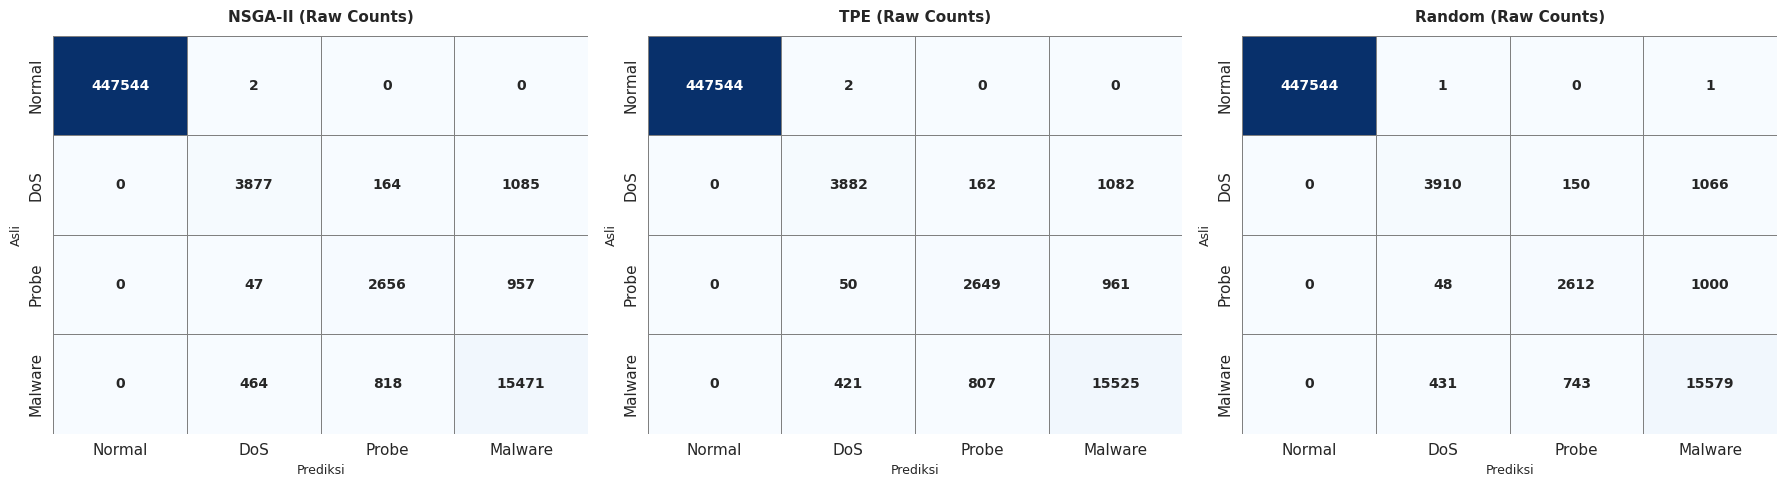


📸 Generating Normalized Confusion Matrix (Sensitivitas/Recall)...


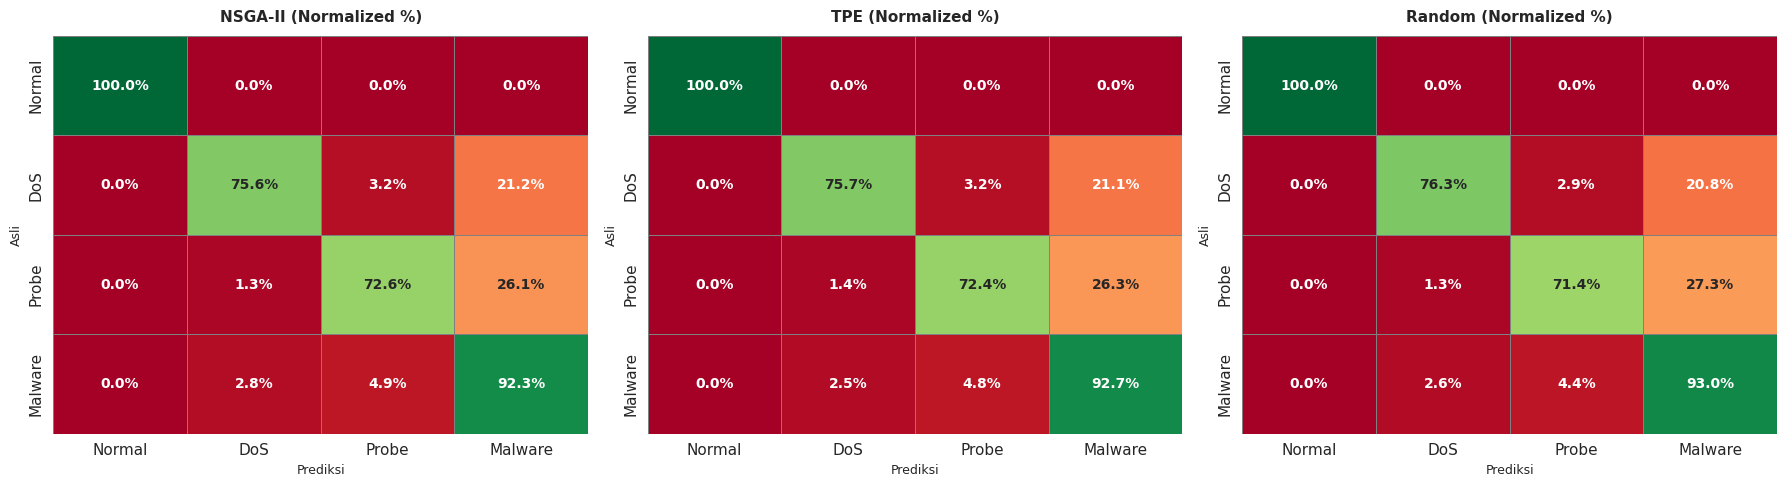


✅ CELL 10A SELESAI. Grafik disimpan: 'cm_raw_heatmap.png' & 'cm_norm_heatmap.png'


In [15]:
# ================================================================================
# Cell 10A: Visualisasi Confusion Matrix (Raw & Normalized Heatmaps)
# ================================================================================

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

print("="*80)
print("📊 BAGIAN A: VISUALISASI CONFUSION MATRIX")
print("="*80)
print("Tujuan: Memvisualisasikan sebaran prediksi vs label asli.")
print()

# 1. Validasi Input
if 'trained_models' not in locals() or len(trained_models) == 0:
    raise ValueError("❌ 'trained_models' tidak ditemukan! Pastikan Cell 8 sudah dijalankan.")

label_map = {0: 'Normal', 1: 'DoS', 2: 'Probe', 3: 'Malware'}
class_names = [label_map.get(i, str(i)) for i in range(len(label_map))]
methods = list(trained_models.keys()) # TPE, Random, NSGA-II

# 2. Helper Plotting
def plot_heatmap(y_true, y_pred, title, ax, fmt, cmap):
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalisasi jika format persentase
    if '%' in fmt:
        with np.errstate(divide='ignore', invalid='ignore'):
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cm = np.nan_to_num(cm)

    sns.heatmap(
        cm, annot=True, fmt=fmt, cmap=cmap, cbar=False, ax=ax,
        xticklabels=class_names, yticklabels=class_names,
        linewidths=0.5, linecolor='grey',
        annot_kws={"size": 10, "weight": "bold"}
    )
    ax.set_title(title, fontsize=11, fontweight='bold', pad=10)
    ax.set_xlabel('Prediksi', fontsize=9)
    ax.set_ylabel('Asli', fontsize=9)

# 3. Plotting Raw Counts
print("📸 Generating Raw Confusion Matrix (Jumlah Sampel)...")
fig1, axes1 = plt.subplots(1, len(methods), figsize=(6 * len(methods), 5))
if len(methods) == 1: axes1 = [axes1]

for i, name in enumerate(methods):
    model = trained_models[name]
    preds = model.predict(X_test_selected)
    plot_heatmap(y_test_final, preds, f"{name} (Raw Counts)", axes1[i], 'd', 'Blues')

plt.tight_layout()
plt.savefig('cm_raw_heatmap.png', dpi=300)
plt.show()

# 4. Plotting Normalized (%)
print("\n📸 Generating Normalized Confusion Matrix (Sensitivitas/Recall)...")
fig2, axes2 = plt.subplots(1, len(methods), figsize=(6 * len(methods), 5))
if len(methods) == 1: axes2 = [axes2]

for i, name in enumerate(methods):
    model = trained_models[name]
    preds = model.predict(X_test_selected)
    plot_heatmap(y_test_final, preds, f"{name} (Normalized %)", axes2[i], '.1%', 'RdYlGn')

plt.tight_layout()
plt.savefig('cm_norm_heatmap.png', dpi=300)
plt.show()

print("\n✅ CELL 10A SELESAI. Grafik disimpan: 'cm_raw_heatmap.png' & 'cm_norm_heatmap.png'")

📝 BAGIAN B: ANALISIS STATISTIK & POLA KESALAHAN
Tujuan: Mengukur reliabilitas (Kappa) dan mendeteksi kesalahan spesifik.

🔹 Menghitung Reliabilitas Model (Cohen's Kappa)...
 Metode  Kappa Score                  Interpretasi
 Random       0.9298 Almost Perfect (Sangat Andal)
    TPE       0.9289 Almost Perfect (Sangat Andal)
NSGA-II       0.9278 Almost Perfect (Sangat Andal)


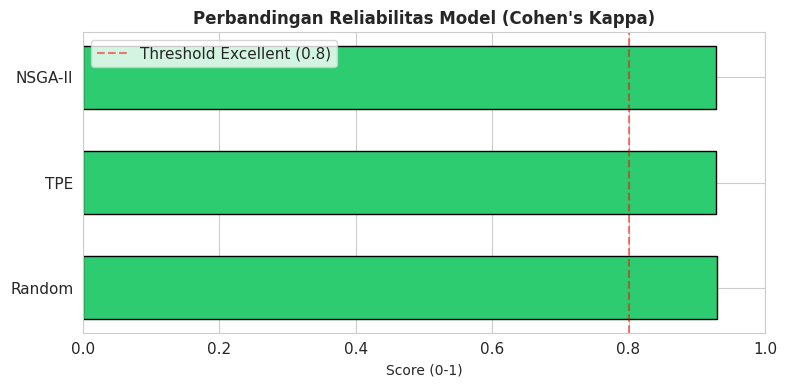


🔹 Bedah Kesalahan (Top 3 Misclassification per Metode):
------------------------------------------------------------
📌 Analisis Metode: NSGA-II
   ⚠️  Asli 'DoS' --> Salah deteksi jadi 'Malware'
       Jumlah: 1085 sampel (21.2% dari total DoS)
   ⚠️  Asli 'Probe' --> Salah deteksi jadi 'Malware'
       Jumlah: 957 sampel (26.1% dari total Probe)
   ⚠️  Asli 'Malware' --> Salah deteksi jadi 'Probe'
       Jumlah: 818 sampel (4.9% dari total Malware)

📌 Analisis Metode: TPE
   ⚠️  Asli 'DoS' --> Salah deteksi jadi 'Malware'
       Jumlah: 1082 sampel (21.1% dari total DoS)
   ⚠️  Asli 'Probe' --> Salah deteksi jadi 'Malware'
       Jumlah: 961 sampel (26.3% dari total Probe)
   ⚠️  Asli 'Malware' --> Salah deteksi jadi 'Probe'
       Jumlah: 807 sampel (4.8% dari total Malware)

📌 Analisis Metode: Random
   ⚠️  Asli 'DoS' --> Salah deteksi jadi 'Malware'
       Jumlah: 1066 sampel (20.8% dari total DoS)
   ⚠️  Asli 'Probe' --> Salah deteksi jadi 'Malware'
       Jumlah: 1000 sampel (27

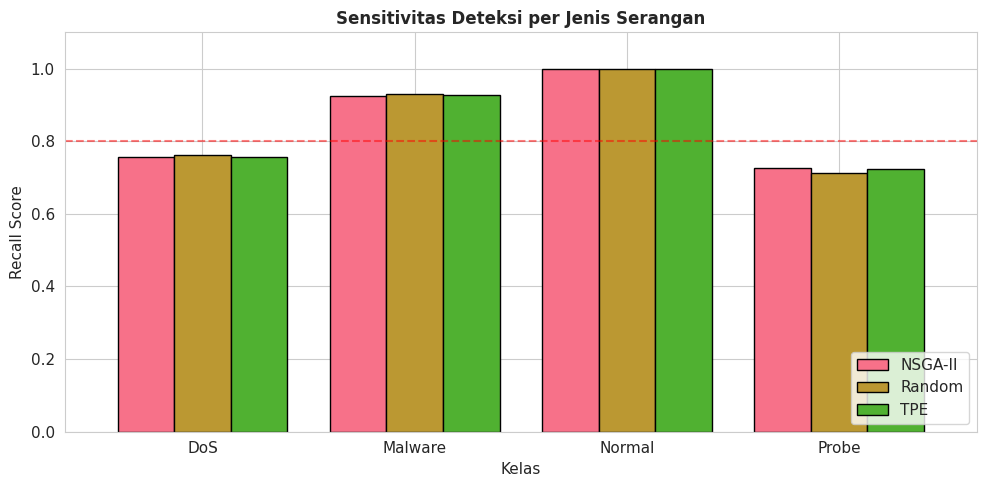


✅ CELL 10B SELESAI. Analisis tersimpan.


In [16]:
# ================================================================================
# Cell 10B: Analisis Statistik (Cohen's Kappa & Error Breakdown)
# ================================================================================

import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt

print("="*80)
print("📝 BAGIAN B: ANALISIS STATISTIK & POLA KESALAHAN")
print("="*80)
print("Tujuan: Mengukur reliabilitas (Kappa) dan mendeteksi kesalahan spesifik.")
print()

# 1. Hitung Cohen's Kappa
kappa_data = []

print("🔹 Menghitung Reliabilitas Model (Cohen's Kappa)...")
for name, model in trained_models.items():
    preds = model.predict(X_test_selected)
    score = cohen_kappa_score(y_test_final, preds)
    
    interpretasi = "Moderate"
    if score > 0.8: interpretasi = "Almost Perfect (Sangat Andal)"
    elif score > 0.6: interpretasi = "Substantial (Andal)"
    
    kappa_data.append({'Metode': name, 'Kappa Score': score, 'Interpretasi': interpretasi})

# Tampilkan Tabel
kappa_df = pd.DataFrame(kappa_data).sort_values('Kappa Score', ascending=False)
print(kappa_df.to_string(index=False, float_format="%.4f"))

# 2. Visualisasi Kappa Comparison
plt.figure(figsize=(8, 4))
colors = ['#2ecc71' if x > 0.8 else '#f1c40f' for x in kappa_df['Kappa Score']]
plt.barh(kappa_df['Metode'], kappa_df['Kappa Score'], color=colors, edgecolor='black', height=0.6)
plt.title("Perbandingan Reliabilitas Model (Cohen's Kappa)", fontsize=12, fontweight='bold')
plt.xlabel("Score (0-1)", fontsize=10)
plt.xlim(0, 1.0)
plt.axvline(0.8, color='red', linestyle='--', alpha=0.5, label='Threshold Excellent (0.8)')
plt.legend()
plt.tight_layout()
plt.savefig('kappa_comparison.png', dpi=300)
plt.show()

# 3. Analisis Pola Kesalahan (Deep Dive)
print("\n🔹 Bedah Kesalahan (Top 3 Misclassification per Metode):")
print("-" * 60)

for name in trained_models.keys():
    print(f"📌 Analisis Metode: {name}")
    model = trained_models[name]
    preds = model.predict(X_test_selected)
    cm = confusion_matrix(y_test_final, preds)
    
    # Cari kesalahan (Off-diagonal)
    errors = []
    for r in range(len(class_names)): # Asli
        for c in range(len(class_names)): # Prediksi
            if r != c and cm[r, c] > 0:
                errors.append({
                    'Asli': class_names[r],
                    'Diprediksi': class_names[c],
                    'Jumlah': cm[r, c],
                    'Persentase': f"{(cm[r, c] / cm[r].sum())*100:.1f}% dari total {class_names[r]}"
                })
    
    # Tampilkan Top 3 Error
    if errors:
        errors_df = pd.DataFrame(errors).sort_values('Jumlah', ascending=False).head(3)
        for _, row in errors_df.iterrows():
            print(f"   ⚠️  Asli '{row['Asli']}' --> Salah deteksi jadi '{row['Diprediksi']}'")
            print(f"       Jumlah: {row['Jumlah']} sampel ({row['Persentase']})")
    else:
        print("   ✅ Sempurna! Tidak ada kesalahan klasifikasi.")
    print()

# 4. Grafik Perbandingan Recall per Kelas (Summary Akhir)
print("🔹 Ringkasan Sensitivitas (Recall) per Kelas Serangan...")
recall_list = []
for name, model in trained_models.items():
    preds = model.predict(X_test_selected)
    cm = confusion_matrix(y_test_final, preds)
    recalls = np.diag(cm) / cm.sum(axis=1) # Recall per kelas
    for idx, val in enumerate(recalls):
        recall_list.append({'Metode': name, 'Kelas': class_names[idx], 'Recall': val})

df_recall = pd.DataFrame(recall_list).pivot(index='Kelas', columns='Metode', values='Recall')
ax = df_recall.plot(kind='bar', figsize=(10, 5), width=0.8, edgecolor='black')
plt.title("Sensitivitas Deteksi per Jenis Serangan", fontweight='bold')
plt.ylabel("Recall Score")
plt.ylim(0, 1.1)
plt.axhline(0.8, color='red', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('recall_summary_chart.png', dpi=300)
plt.show()

print("\n✅ CELL 10B SELESAI. Analisis tersimpan.")

# Visualisasi C: Hyperparameter Importance (Analisis Faktor Penentu)

🔬 HYPERPARAMETER IMPORTANCE ANALYSIS (RANDOM FOREST SURROGATE)

✅ Studies siap dianalisis: ['TPE', 'NSGA-II', 'Random']

📌 Menganalisis Study: TPE
------------------------------------------------------------
   🔹 Top 3 Param untuk F1-Score:
      - learning_rate       : 0.3770
      - subsample           : 0.1605
      - n_estimators        : 0.0804


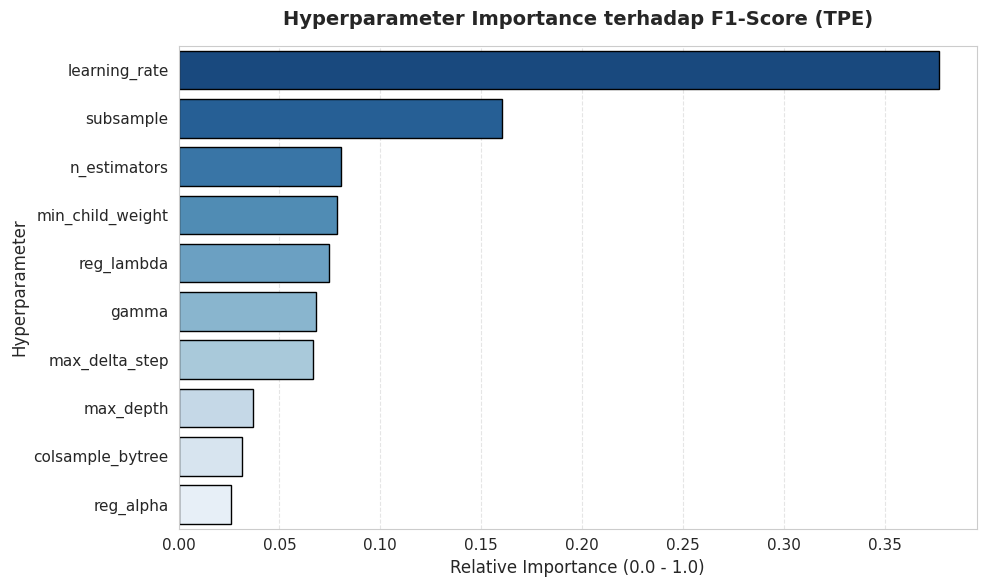

   ✅ Grafik disimpan: importance_f1_tpe.png
   🔹 Top 3 Param untuk Latency:
      - n_estimators        : 0.6885
      - max_depth           : 0.1036
      - subsample           : 0.0592


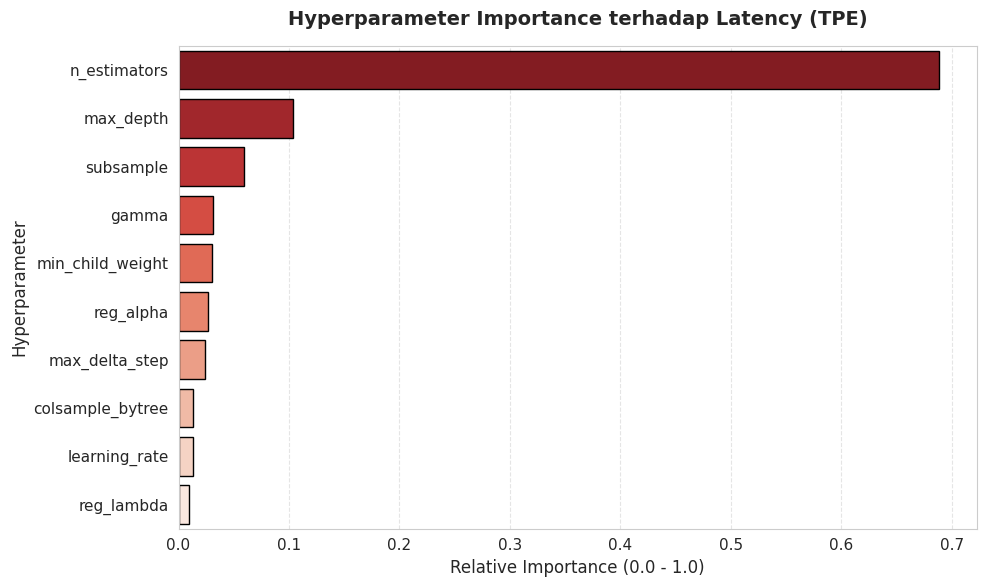

   ✅ Grafik disimpan: importance_time_tpe.png

📌 Menganalisis Study: NSGA-II
------------------------------------------------------------
   🔹 Top 3 Param untuk F1-Score:
      - learning_rate       : 0.6873
      - reg_lambda          : 0.0880
      - subsample           : 0.0869


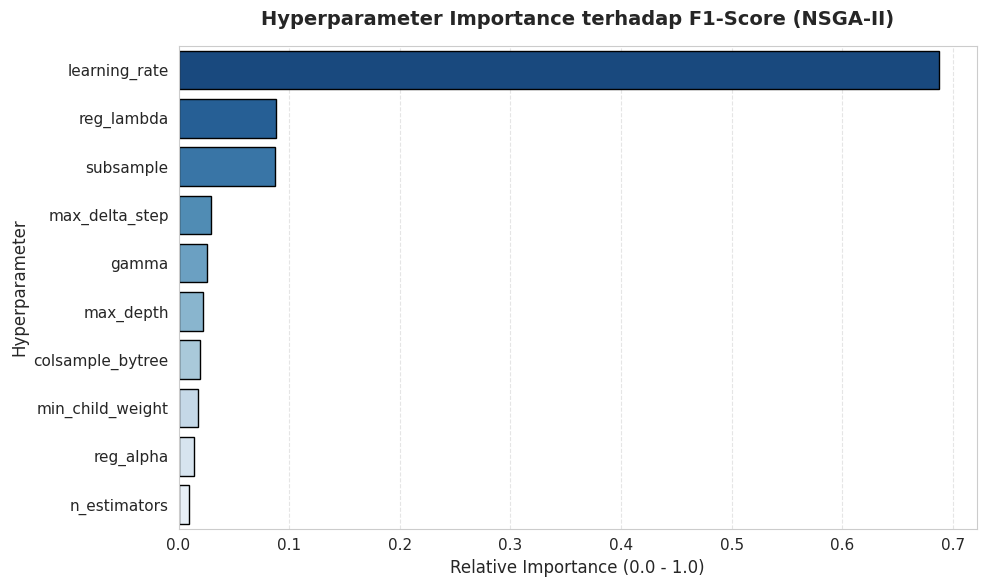

   ✅ Grafik disimpan: importance_f1_nsga-ii.png
   🔹 Top 3 Param untuk Latency:
      - n_estimators        : 0.7110
      - max_depth           : 0.1569
      - reg_alpha           : 0.0302


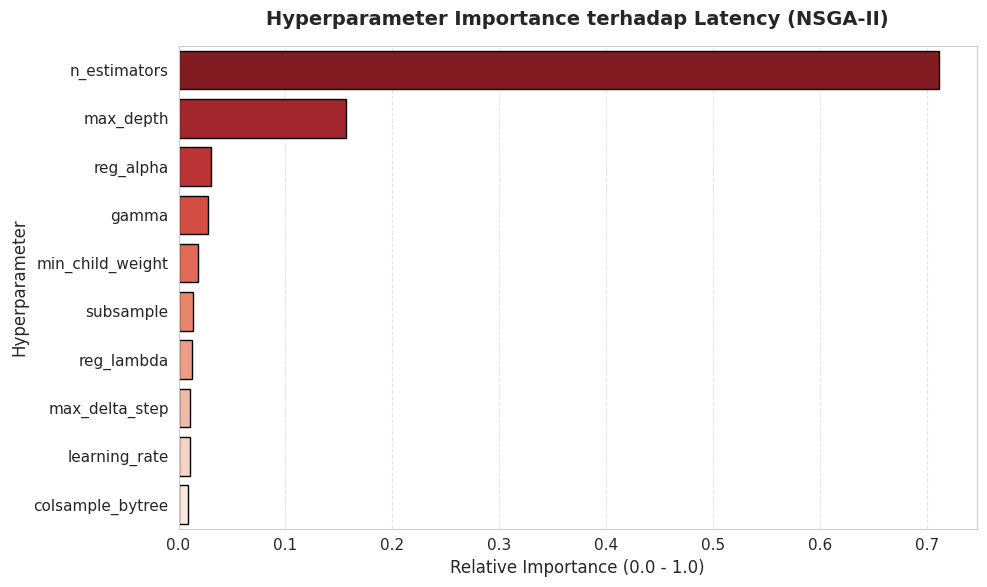

   ✅ Grafik disimpan: importance_time_nsga-ii.png

📌 Menganalisis Study: Random
------------------------------------------------------------
   🔹 Top 3 Param untuk F1-Score:
      - learning_rate       : 0.6550
      - max_depth           : 0.0739
      - subsample           : 0.0714


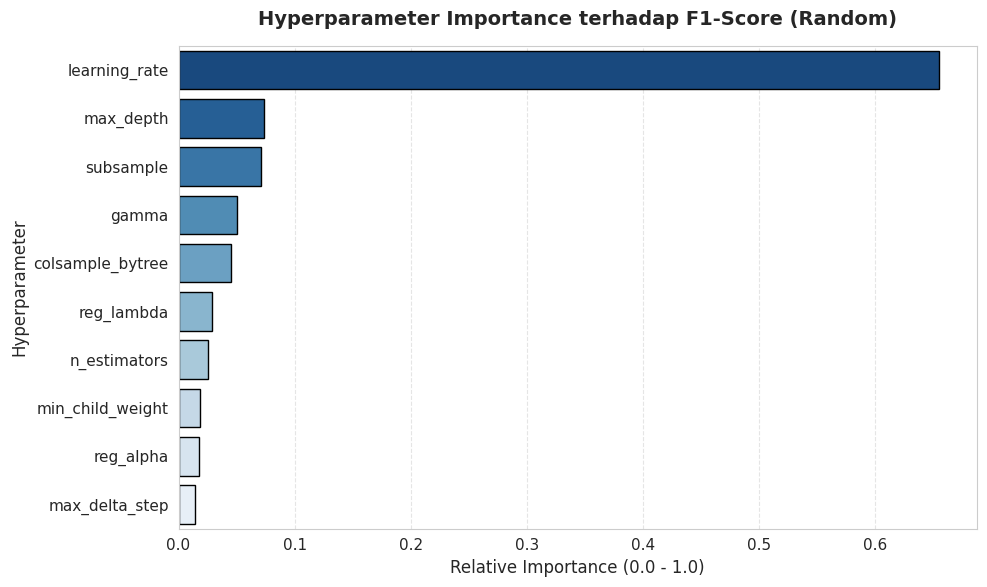

   ✅ Grafik disimpan: importance_f1_random.png
   🔹 Top 3 Param untuk Latency:
      - n_estimators        : 0.7015
      - max_depth           : 0.1149
      - gamma               : 0.0403


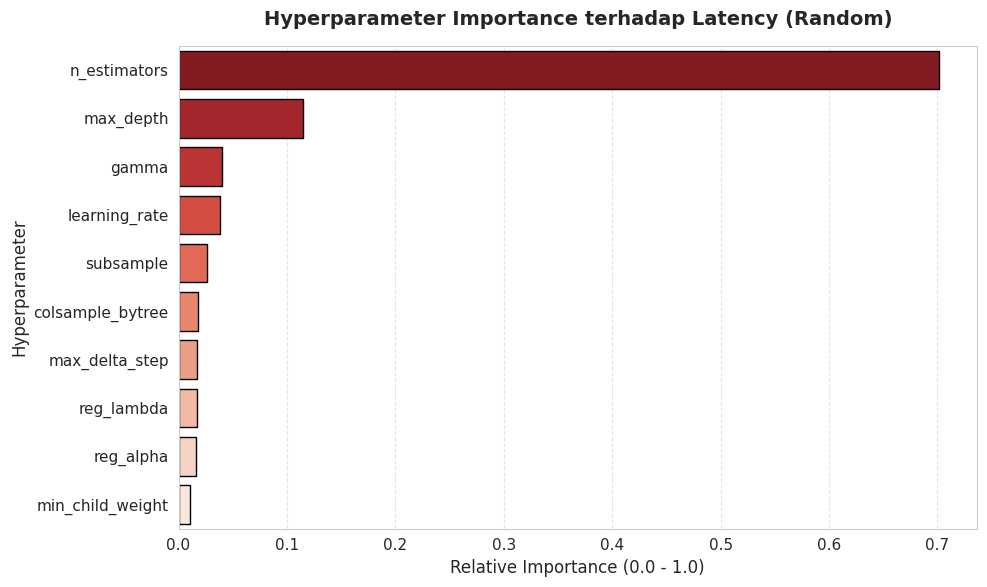

   ✅ Grafik disimpan: importance_time_random.png

💾 File rekap disimpan: hyperparameter_importance_summary.csv


In [17]:
# ================================================================================
# Cell 11: Hyperparameter Importance Analysis (Surrogate RF) - VISUAL UPGRADE
# ================================================================================

from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 80)
print("🔬 HYPERPARAMETER IMPORTANCE ANALYSIS (RANDOM FOREST SURROGATE)")
print("=" * 80)
print()

# ================================================================================
# 1. VALIDASI STUDY DARI CELL 5-7
# ================================================================================

studies = {}
if 'study_tpe' in locals() and study_tpe: studies['TPE'] = study_tpe
if 'study_nsga' in locals() and study_nsga: studies['NSGA-II'] = study_nsga
if 'study_random' in locals() and study_random: studies['Random'] = study_random

if not studies:
    raise RuntimeError("❌ Tidak ada study tersedia! Jalankan optimasi terlebih dahulu.")

print(f"✅ Studies siap dianalisis: {list(studies.keys())}\n")

# ================================================================================
# 2. FUNGSI ANALISIS IMPORTANCE (CORE LOGIC)
# ================================================================================

def get_rf_importance(study, objective_name, objective_index):
    """
    Menghitung importance menggunakan Random Forest Regressor.
    """
    # Ambil trial yang sukses
    trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

    if len(trials) < 5:
        print(f"   ⚠️ Data trial terlalu sedikit untuk {objective_name} (<5). Skip.")
        return None

    # Ekstrak parameter numerik & target value
    data = []
    for t in trials:
        row = {k: v for k, v in t.params.items() if isinstance(v, (int, float))}
        row['target'] = t.values[objective_index]
        data.append(row)

    df = pd.DataFrame(data)
    
    # Cek variansi target (jika semua F1 sama, tidak bisa dihitung importance-nya)
    if df['target'].nunique() <= 1:
        print(f"   ⚠️ Target {objective_name} konstan (tidak ada variasi). Skip.")
        return None

    X = df.drop(columns='target')
    y = df['target']

    # Latih Random Forest Surrogate
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    model.fit(X, y)

    # Ambil Feature Importance
    importances = pd.Series(model.feature_importances_, index=X.columns)
    return importances.sort_values(ascending=False)

# ================================================================================
# 3. FUNGSI VISUALISASI (SEABORN STYLE)
# ================================================================================

def plot_importance(importance_series, title, filename, color_palette="viridis"):
    plt.figure(figsize=(10, 6))
    
    # Plot Bar Chart
    sns.barplot(
        x=importance_series.values,
        y=importance_series.index,
        palette=color_palette,
        edgecolor='black'
    )
    
    plt.title(title, fontsize=14, fontweight='bold', pad=15)
    plt.xlabel("Relative Importance (0.0 - 1.0)", fontsize=12)
    plt.ylabel("Hyperparameter", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # Simpan
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"   ✅ Grafik disimpan: {filename}")

# ================================================================================
# 4. EKSEKUSI ANALISIS
# ================================================================================

# Dictionary untuk menyimpan hasil CSV gabungan
combined_importance = []

for method_name, study in studies.items():
    print(f"📌 Menganalisis Study: {method_name}")
    print("-" * 60)
    
    # --- Analisis 1: F1-Score Importance ---
    # Objective index 0 = F1 (Maximize)
    imp_f1 = get_rf_importance(study, "F1-Score", 0)
    
    if imp_f1 is not None:
        print(f"   🔹 Top 3 Param untuk F1-Score:")
        for param, score in imp_f1.head(3).items():
            print(f"      - {param:20s}: {score:.4f}")
            
        plot_importance(
            imp_f1, 
            f"Hyperparameter Importance terhadap F1-Score ({method_name})",
            f"importance_f1_{method_name.lower()}.png",
            "Blues_r"
        )
        
        # Simpan ke list untuk CSV
        for p, s in imp_f1.items():
            combined_importance.append({'Metode': method_name, 'Target': 'F1', 'Param': p, 'Importance': s})

    # --- Analisis 2: Inference Time Importance ---
    # Objective index 1 = Latency (Minimize)
    imp_time = get_rf_importance(study, "Inference Time", 1)
    
    if imp_time is not None:
        print(f"   🔹 Top 3 Param untuk Latency:")
        for param, score in imp_time.head(3).items():
            print(f"      - {param:20s}: {score:.4f}")
            
        plot_importance(
            imp_time, 
            f"Hyperparameter Importance terhadap Latency ({method_name})",
            f"importance_time_{method_name.lower()}.png",
            "Reds_r"
        )

        for p, s in imp_time.items():
            combined_importance.append({'Metode': method_name, 'Target': 'Time', 'Param': p, 'Importance': s})
            
    print()

# ================================================================================
# 5. EXPORT CSV REKAP
# ================================================================================

if combined_importance:
    df_imp = pd.DataFrame(combined_importance)
    df_imp.to_csv("hyperparameter_importance_summary.csv", index=False)
    print("=" * 80)
    print("💾 File rekap disimpan: hyperparameter_importance_summary.csv")
    print("=" * 80)
else:
    print("⚠️ Tidak ada data importance yang dihasilkan.")

# Visualisasi D: Optimization Process Visualization

📈 OPTIMIZATION PROCESS VISUALIZATION - TRACKING KONVERGENSI

ℹ️  Ukuran Validation Set: 378,468 sampel
✅ Studies siap divisualisasi: ['TPE', 'NSGA-II', 'Random']

📋 Mengumpulkan data history...
✅ Total data trials: 90

📊 Membuat Plot Konvergensi...


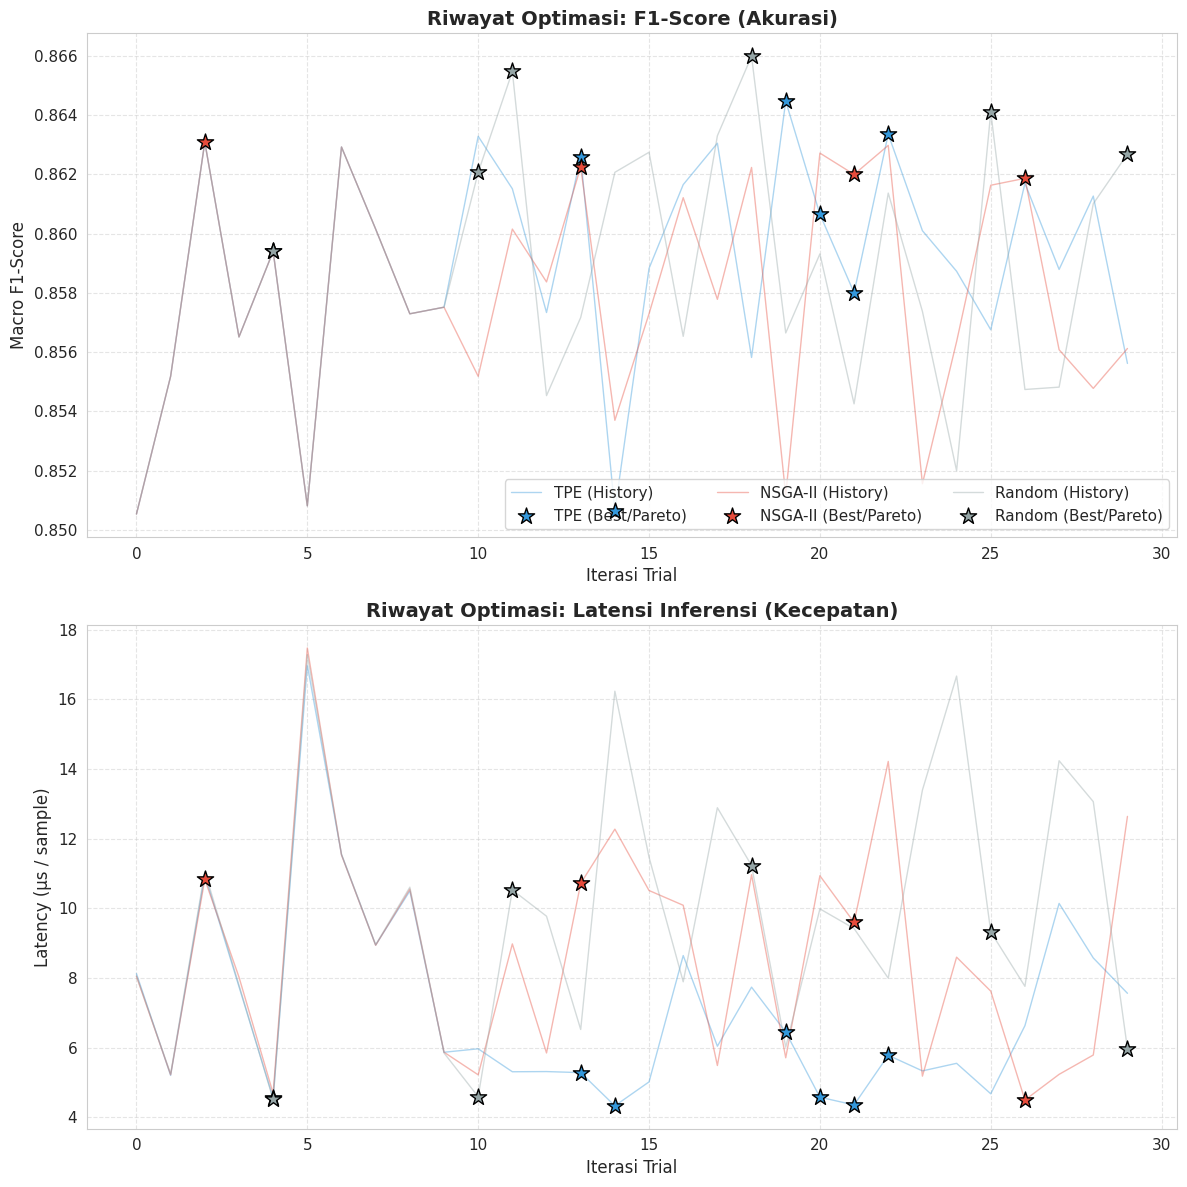

✅ Grafik disimpan: optimization_history_final.png

📈 STATISTIK PENINGKATAN PERFORMA
 Metode  Gain F1 (%)  Gain Lat (%)  Best F1  Best Lat (µs)
    TPE         1.64         46.73     0.86           4.33
NSGA-II         1.47         44.15     0.86           4.49
 Random         1.82         43.96     0.87           4.51

✅ Data history & statistik diekspor ke CSV.


In [18]:
# ================================================================================
# Cell 12: Optimization Process Visualization (Convergence) - FIXED UNITS
# ================================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import optuna

print("="*80)
print("📈 OPTIMIZATION PROCESS VISUALIZATION - TRACKING KONVERGENSI")
print("="*80)
print()

# ================================================================================
# 1. VALIDASI DATA & KONVERSI UNIT
# ================================================================================

# Ambil ukuran validation set untuk konversi waktu
try:
    VAL_SIZE = len(X_val)
    print(f"ℹ️  Ukuran Validation Set: {VAL_SIZE:,} sampel")
except NameError:
    raise ValueError("❌ X_val tidak ditemukan. Jalankan Cell 3 terlebih dahulu!")

available_studies = {}
if 'study_tpe' in locals() and study_tpe: available_studies['TPE'] = study_tpe
if 'study_nsga' in locals() and study_nsga: available_studies['NSGA-II'] = study_nsga
if 'study_random' in locals() and study_random: available_studies['Random'] = study_random

if not available_studies:
    raise ValueError("❌ Tidak ada study yang tersedia! Jalankan Cell 5-7 dulu.")

print(f"✅ Studies siap divisualisasi: {list(available_studies.keys())}\n")

# ================================================================================
# 2. PENGUMPULAN DATA TRIAL
# ================================================================================

print("📋 Mengumpulkan data history...")

all_trials_data = []

for method_name, study in available_studies.items():
    # Filter hanya trial yang sukses
    successful_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    
    # Identifikasi Pareto Trials (Solusi Terbaik)
    pareto_ids = set([t.number for t in study.best_trials])

    for trial in successful_trials:
        # Values[0] = F1, Values[1] = Total Time (Seconds)
        f1_score = trial.values[0]
        raw_time = trial.values[1]
        
        # KONVERSI KE MIKRODETIK
        latency_us = (raw_time / VAL_SIZE) * 1_000_000
        
        all_trials_data.append({
            'Method': method_name,
            'Trial_Number': trial.number,
            'F1_Score': f1_score,
            'Latency_us': latency_us,
            'Is_Pareto': trial.number in pareto_ids
        })

trials_df = pd.DataFrame(all_trials_data)
print(f"✅ Total data trials: {len(trials_df)}")
print()

# ================================================================================
# 3. VISUALISASI OPTIMIZATION HISTORY
# ================================================================================

print("📊 Membuat Plot Konvergensi...")

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Definisi Warna Konsisten
colors = {'TPE': '#3498db', 'NSGA-II': '#e74c3c', 'Random': '#95a5a6'}

# --- PLOT 1: F1-SCORE HISTORY ---
ax1 = axes[0]
for name in available_studies.keys():
    subset = trials_df[trials_df['Method'] == name].sort_values('Trial_Number')
    
    # Plot Garis Tipis (Trajectory)
    ax1.plot(subset['Trial_Number'], subset['F1_Score'], color=colors[name], 
             alpha=0.4, linewidth=1, label=f'{name} (History)')
    
    # Plot Titik Pareto (Bintang Besar)
    pareto_subset = subset[subset['Is_Pareto']]
    ax1.scatter(pareto_subset['Trial_Number'], pareto_subset['F1_Score'], 
                color=colors[name], s=150, marker='*', edgecolors='black', zorder=10,
                label=f'{name} (Best/Pareto)')

ax1.set_title('Riwayat Optimasi: F1-Score (Akurasi)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Macro F1-Score', fontsize=12)
ax1.set_xlabel('Iterasi Trial', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend(loc='lower right', ncol=3)

# --- PLOT 2: LATENCY HISTORY (MIKRODETIK) ---
ax2 = axes[1]
for name in available_studies.keys():
    subset = trials_df[trials_df['Method'] == name].sort_values('Trial_Number')
    
    # Plot Garis Tipis
    ax2.plot(subset['Trial_Number'], subset['Latency_us'], color=colors[name], 
             alpha=0.4, linewidth=1)
    
    # Plot Titik Pareto
    pareto_subset = subset[subset['Is_Pareto']]
    ax2.scatter(pareto_subset['Trial_Number'], pareto_subset['Latency_us'], 
                color=colors[name], s=150, marker='*', edgecolors='black', zorder=10)

ax2.set_title('Riwayat Optimasi: Latensi Inferensi (Kecepatan)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Latency (µs / sample)', fontsize=12)
ax2.set_xlabel('Iterasi Trial', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.5)
# ax2.set_yscale('log') # Opsional: Aktifkan jika rentang waktu sangat jauh

plt.tight_layout()
plt.savefig('optimization_history_final.png', dpi=300)
plt.show()

print("✅ Grafik disimpan: optimization_history_final.png")
print()

# ================================================================================
# 4. ANALISIS PENINGKATAN (IMPROVEMENT STATS)
# ================================================================================

print("="*60)
print("📈 STATISTIK PENINGKATAN PERFORMA")
print("="*60)

stats_list = []

for name in available_studies.keys():
    subset = trials_df[trials_df['Method'] == name].sort_values('Trial_Number')
    
    # Baseline (Trial Pertama) vs Best (Max F1 / Min Latency)
    first_f1 = subset.iloc[0]['F1_Score']
    best_f1 = subset['F1_Score'].max()
    
    first_lat = subset.iloc[0]['Latency_us']
    best_lat = subset['Latency_us'].min()
    
    imp_f1 = ((best_f1 - first_f1) / first_f1) * 100
    imp_lat = ((first_lat - best_lat) / first_lat) * 100
    
    stats_list.append({
        'Metode': name,
        'First F1': first_f1,
        'Best F1': best_f1,
        'Gain F1 (%)': imp_f1,
        'First Lat (µs)': first_lat,
        'Best Lat (µs)': best_lat,
        'Gain Lat (%)': imp_lat
    })

stats_df = pd.DataFrame(stats_list)
print(stats_df[['Metode', 'Gain F1 (%)', 'Gain Lat (%)', 'Best F1', 'Best Lat (µs)']].to_string(index=False, float_format="%.2f"))

# Export Data untuk Lampiran
trials_df.to_csv('history_trials_data.csv', index=False)
stats_df.to_csv('improvement_stats.csv', index=False)
print("\n✅ Data history & statistik diekspor ke CSV.")

# Visualisasi E: Feature Importance XGBoost

🌳 FEATURE IMPORTANCE ANALYSIS - XGBOOST (GAIN)

🔍 Validasi ketersediaan models dari Cell 8...
✅ Models tersedia: ['NSGA-II', 'TPE', 'Random']

📊 Mengekstrak Feature Importance (Gain)...

📌 Metode: NSGA-II
------------------------------------------------------------
   Top 5 Fitur Paling Berpengaruh:
      - MIN_TTL             : 3941.2974
      - MAX_TTL             : 3029.7402
      - MIN_IP_PKT_LEN      : 1360.9132
      - SHORTEST_FLOW_PKT   : 824.6616
      - DNS_QUERY_TYPE      : 751.8260

📌 Metode: TPE
------------------------------------------------------------
   Top 5 Fitur Paling Berpengaruh:
      - MIN_TTL             : 3972.3142
      - MAX_TTL             : 3901.4917
      - MIN_IP_PKT_LEN      : 1344.5006
      - SHORTEST_FLOW_PKT   : 661.4661
      - DNS_QUERY_TYPE      : 638.9400

📌 Metode: Random
------------------------------------------------------------
   Top 5 Fitur Paling Berpengaruh:
      - MIN_TTL             : 5002.6001
      - MAX_TTL             : 4019.579

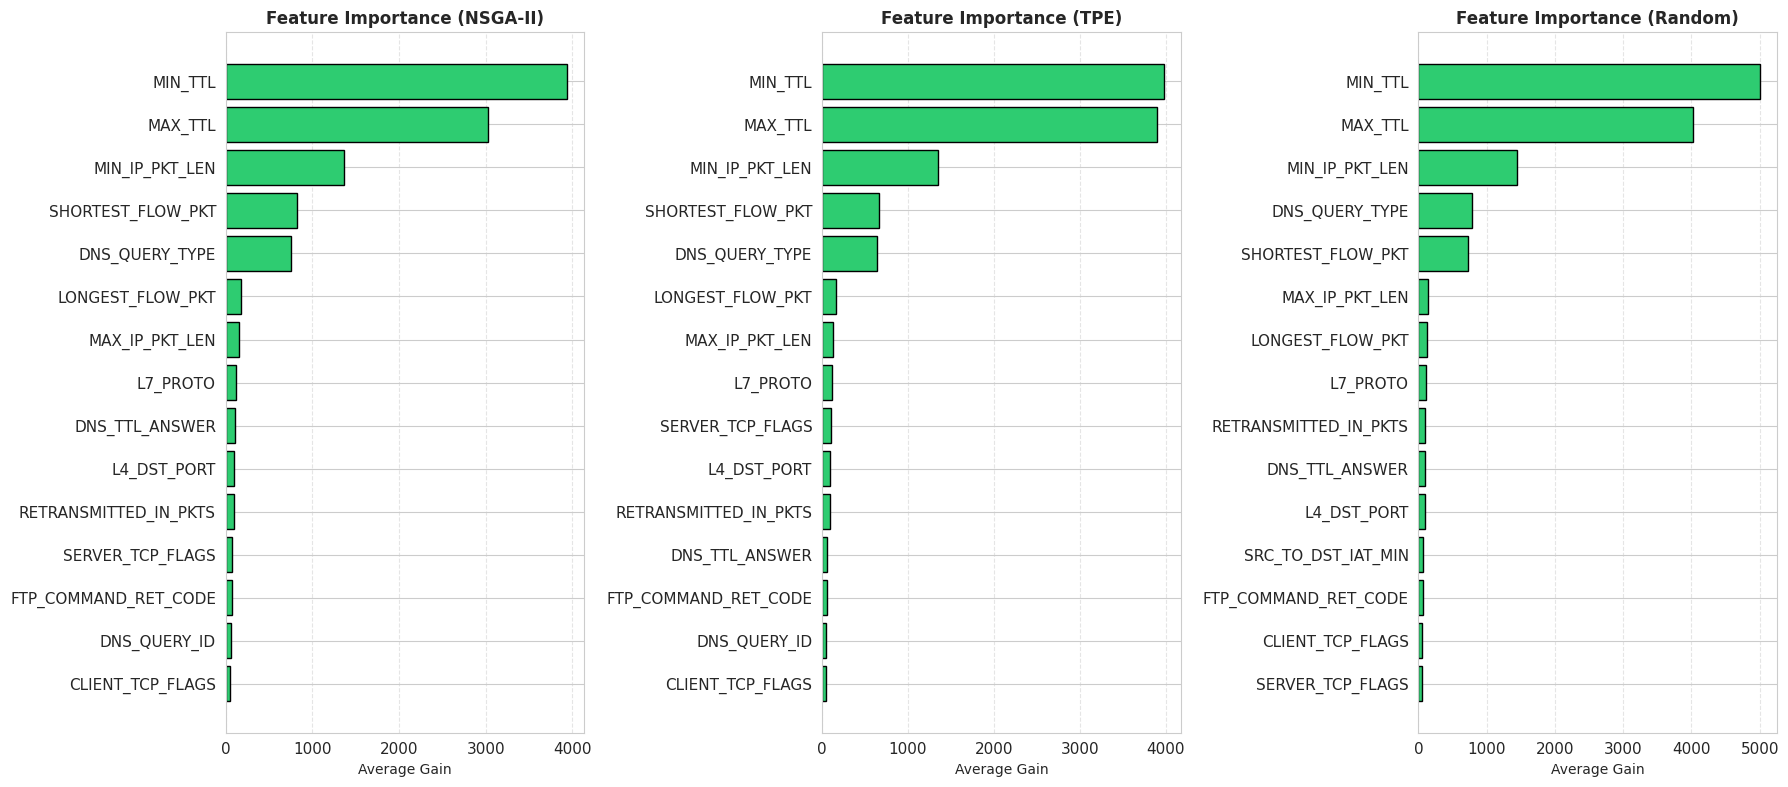

✅ Gambar disimpan: feature_importance_bar_comparison.png

📊 Membuat Heatmap Komparasi...


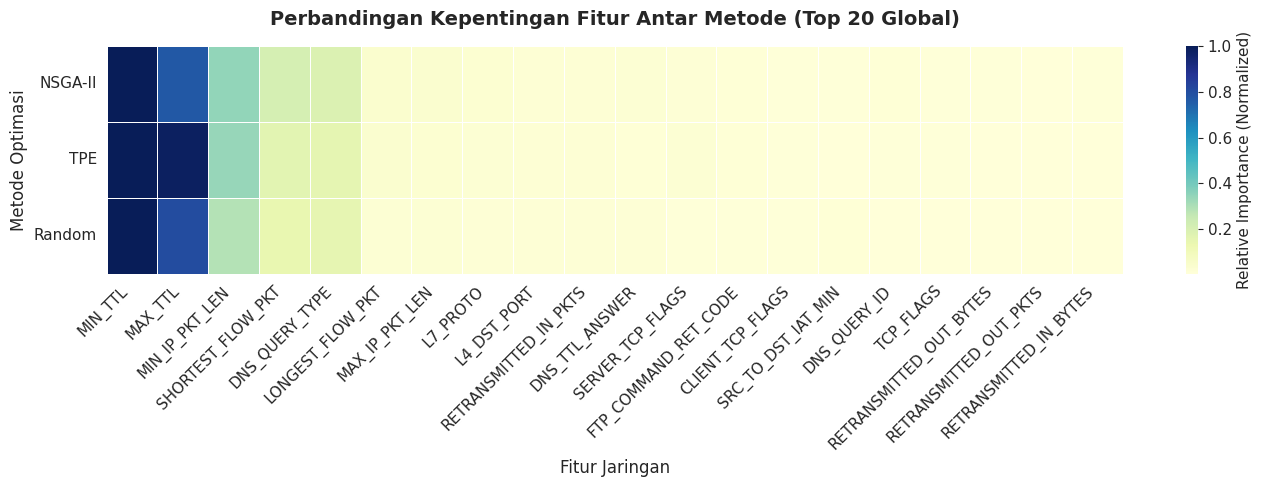

✅ Gambar disimpan: feature_importance_heatmap_comparison.png

💾 Export Data Importance...
✅ File CSV disimpan: feature_importance_all_methods.csv

✅ CELL 13 SELESAI.


In [19]:
# ================================================================================
# Cell 13: Feature Importance Analysis (XGBoost) - FIXED
# ================================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xgboost as xgb

print("=" * 80)
print("🌳 FEATURE IMPORTANCE ANALYSIS - XGBOOST (GAIN)")
print("=" * 80)
print()

# ================================================================================
# 1. VALIDASI KETERSEDIAAN MODEL
# ================================================================================

print("🔍 Validasi ketersediaan models dari Cell 8...")

# PENTING: Gunakan 'trained_models' dari Cell 8
if 'trained_models' not in locals() or len(trained_models) == 0:
    raise ValueError("❌ 'trained_models' tidak ditemukan! Jalankan Cell 8 terlebih dahulu.")

print(f"✅ Models tersedia: {list(trained_models.keys())}")
print()

# ================================================================================
# 2. EKSTRAK FEATURE IMPORTANCE (GAIN)
# ================================================================================

print("📊 Mengekstrak Feature Importance (Gain)...")
feature_importance_data = {}

for name, model in trained_models.items():
    print(f"\n📌 Metode: {name}")
    print("-" * 60)
    
    # Ambil booster dari model
    booster = model.get_booster()
    
    # Ambil importance type 'gain' (paling relevan untuk akurasi)
    importance_dict = booster.get_score(importance_type='gain')
    
    # Mapping agar jika ada fitur yang tidak terpilih tetap muncul dengan nilai 0
    all_features = booster.feature_names
    full_importance = {f: importance_dict.get(f, 0.0) for f in all_features}
    
    # Simpan
    feature_importance_data[name] = full_importance
    
    # Tampilkan Top 5
    sorted_imp = sorted(full_importance.items(), key=lambda x: x[1], reverse=True)
    print("   Top 5 Fitur Paling Berpengaruh:")
    for f_name, f_val in sorted_imp[:5]:
        print(f"      - {f_name:20s}: {f_val:.4f}")

# ================================================================================
# 3. VISUALISASI 1: TOP 15 FEATURES PER MODEL (BAR CHART)
# ================================================================================

print("\n📊 Membuat Bar Chart Top 15 Features...")

n_methods = len(feature_importance_data)
fig, axes = plt.subplots(1, n_methods, figsize=(6 * n_methods, 8))
if n_methods == 1: axes = [axes]

for ax, (name, imp_dict) in zip(axes, feature_importance_data.items()):
    # Ambil Top 15
    top_feats = sorted(imp_dict.items(), key=lambda x: x[1], reverse=True)[:15]
    feats = [x[0] for x in top_feats]
    scores = [x[1] for x in top_feats]
    
    # Plot Horizontal Bar
    ax.barh(feats, scores, color='#2ecc71', edgecolor='black')
    ax.invert_yaxis() # Fitur terpenting di atas
    ax.set_title(f"Feature Importance ({name})", fontsize=12, fontweight='bold')
    ax.set_xlabel("Average Gain", fontsize=10)
    ax.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("feature_importance_bar_comparison.png", dpi=300)
plt.show()
print("✅ Gambar disimpan: feature_importance_bar_comparison.png")

# ================================================================================
# 4. VISUALISASI 2: HEATMAP COMPARISON (TOP 20 GLOBAL)
# ================================================================================

print("\n📊 Membuat Heatmap Komparasi...")

# 1. Cari Top 20 Fitur Global (Rata-rata dari semua model)
global_scores = {}
for imp in feature_importance_data.values():
    for f, v in imp.items():
        global_scores[f] = global_scores.get(f, 0) + v

# Ambil Top 20 Global
top_20_global = [x[0] for x in sorted(global_scores.items(), key=lambda x: x[1], reverse=True)[:20]]

# 2. Buat DataFrame untuk Heatmap
heatmap_data = []
for name in feature_importance_data.keys():
    row = [feature_importance_data[name].get(f, 0) for f in top_20_global]
    heatmap_data.append(row)

df_heatmap = pd.DataFrame(heatmap_data, columns=top_20_global, index=feature_importance_data.keys())

# 3. Normalisasi MinMax per Baris (agar warnanya adil antar metode)
#    (Opsional: bisa dimatikan jika ingin lihat nilai absolut)
df_heatmap_norm = df_heatmap.div(df_heatmap.max(axis=1), axis=0)

plt.figure(figsize=(14, 5))
sns.heatmap(
    df_heatmap_norm, 
    cmap="YlGnBu", 
    annot=False, # Annotasi angka dimatikan agar bersih
    linewidths=0.5,
    cbar_kws={'label': 'Relative Importance (Normalized)'}
)
plt.title("Perbandingan Kepentingan Fitur Antar Metode (Top 20 Global)", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Fitur Jaringan", fontsize=12)
plt.ylabel("Metode Optimasi", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig("feature_importance_heatmap_comparison.png", dpi=300)
plt.show()
print("✅ Gambar disimpan: feature_importance_heatmap_comparison.png")

# ================================================================================
# 5. EXPORT CSV
# ================================================================================
print("\n💾 Export Data Importance...")

# Gabungkan jadi satu CSV
df_export = pd.DataFrame(feature_importance_data)
df_export.index.name = 'Feature'
df_export.to_csv("feature_importance_all_methods.csv")
print("✅ File CSV disimpan: feature_importance_all_methods.csv")
print("\n✅ CELL 13 SELESAI.")

# Visualisasi F: Detailed Performance Metrics per Class

📊 DETAILED PERFORMANCE METRICS PER CLASS

🔍 Validasi ketersediaan data...
✅ Models tersedia: ['NSGA-II', 'TPE', 'Random']
✅ Test samples: 473,085

📊 Menghitung Precision, Recall, F1 per kelas...
   ✅ Metrics NSGA-II calculated.
   ✅ Metrics TPE calculated.
   ✅ Metrics Random calculated.

📊 Membuat Grouped Bar Chart...


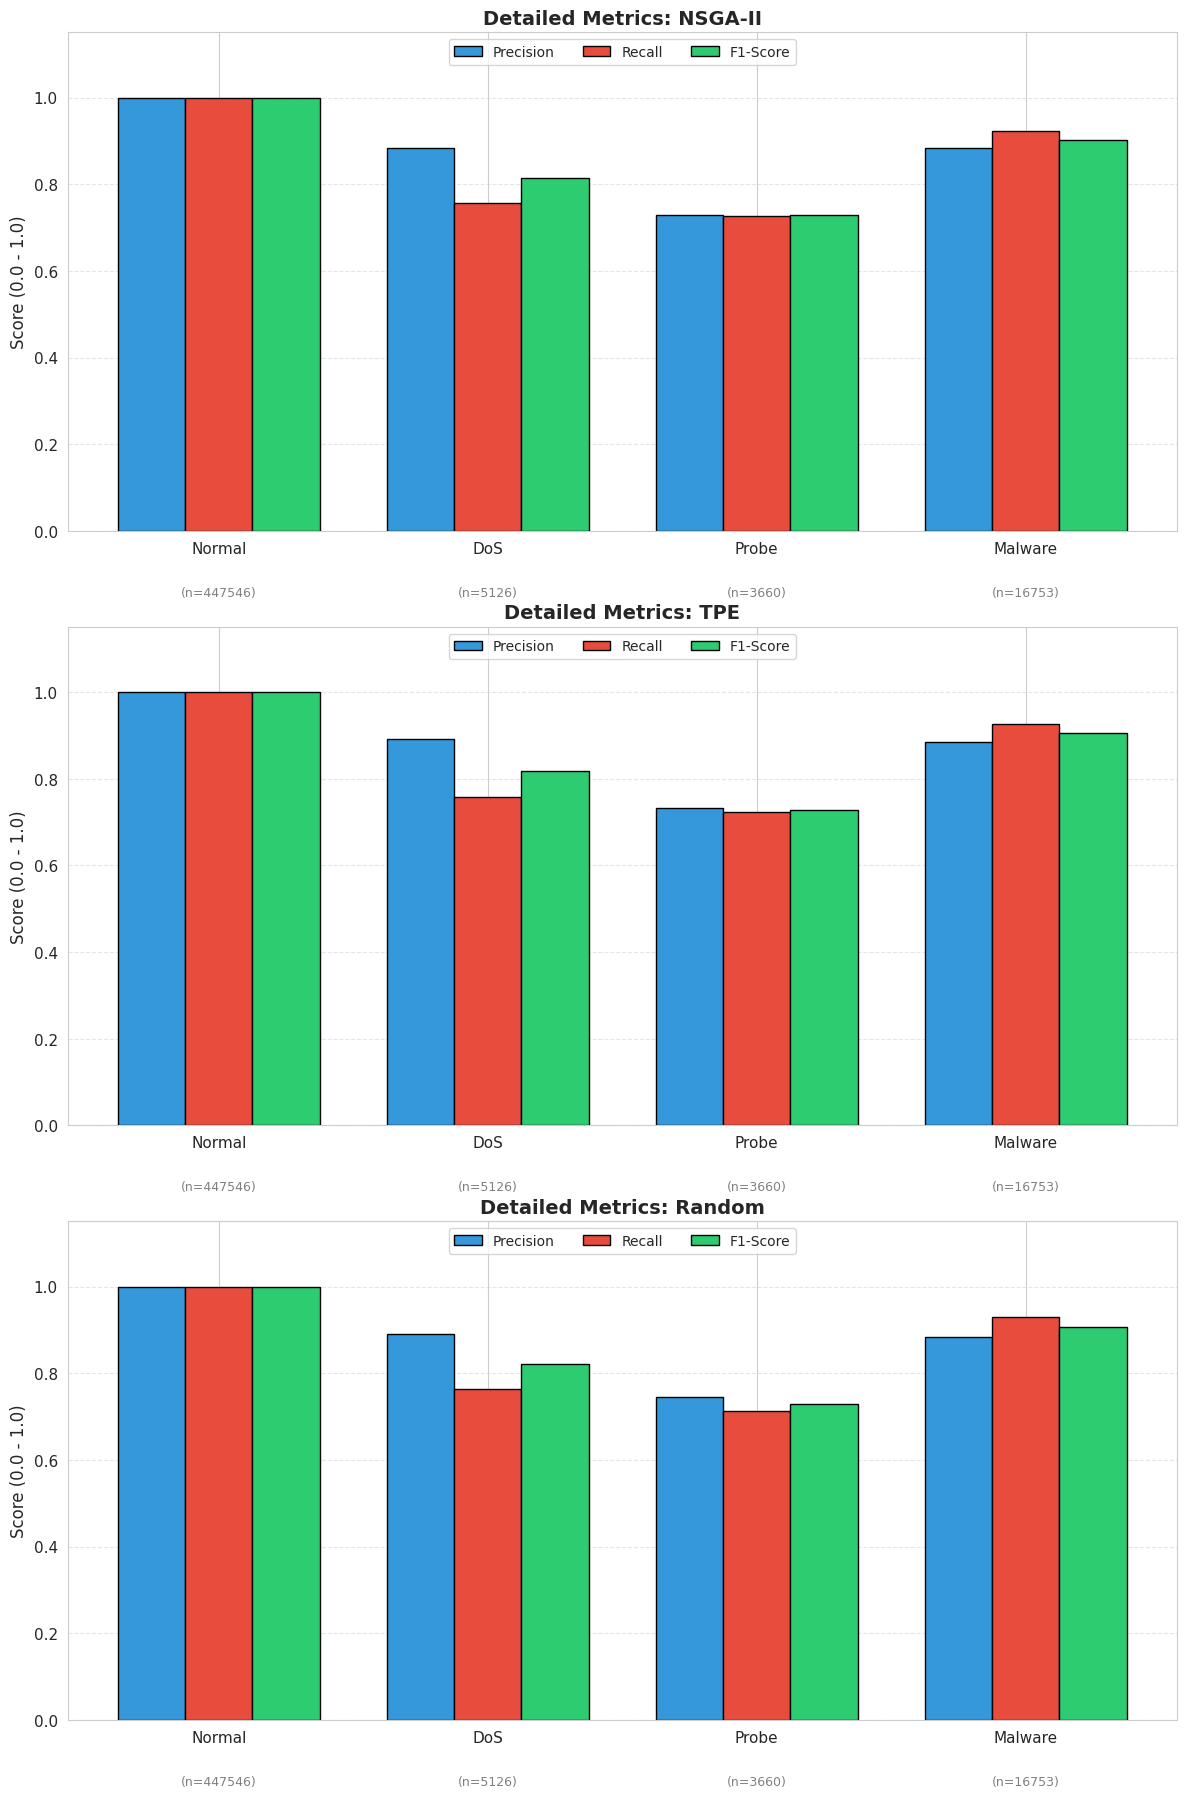

✅ Gambar disimpan: metrics_grouped_bar.png

📊 Membuat Heatmap F1-Score Comparison...


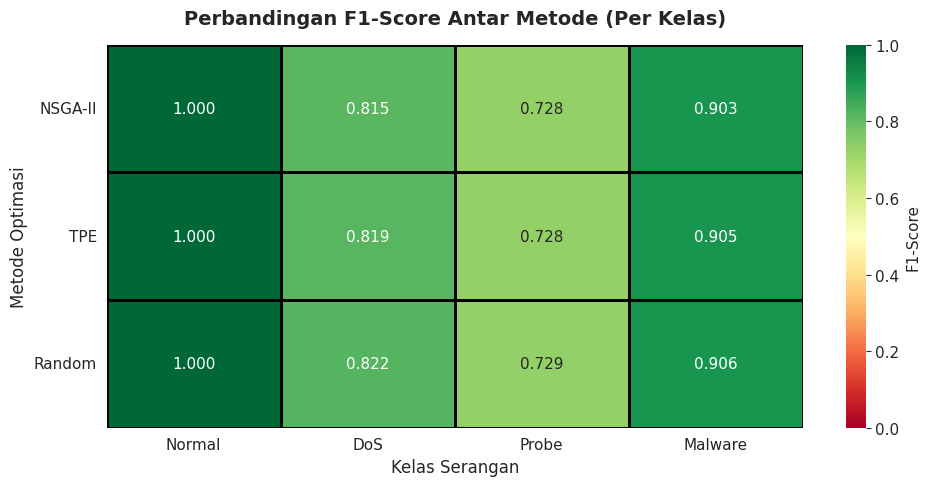

✅ Gambar disimpan: metrics_f1_heatmap.png

📊 Membuat Precision-Recall Scatter Plot...


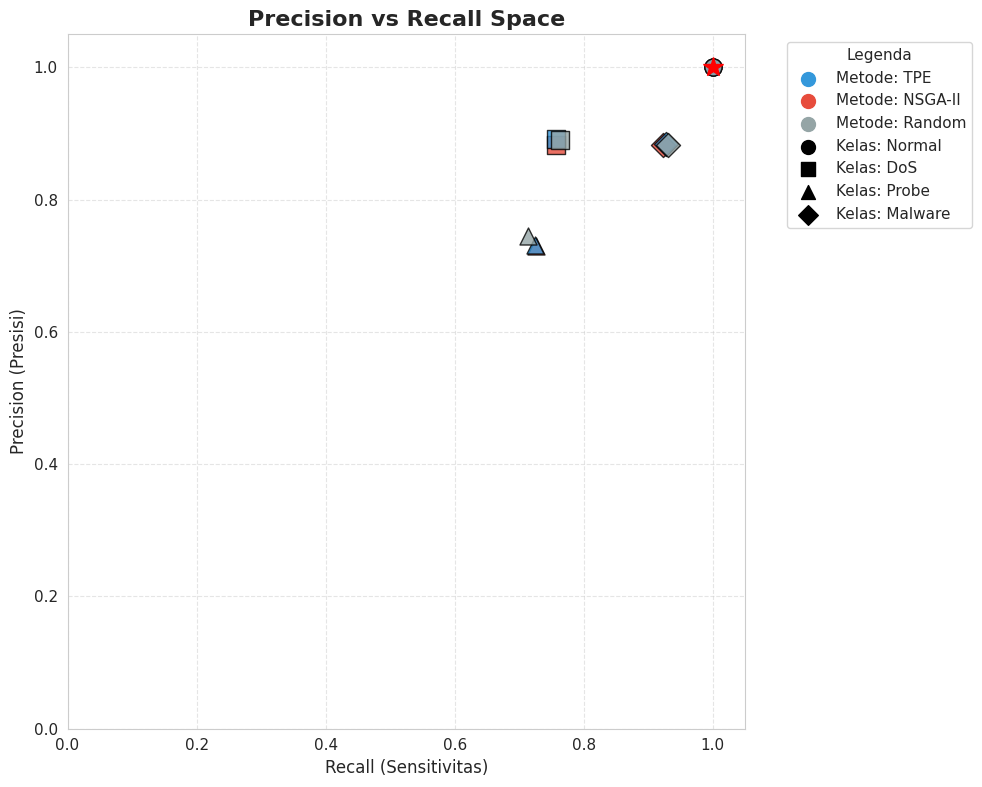

✅ Gambar disimpan: metrics_pr_scatter.png

💾 Export CSV Metrics...
✅ Disimpan: metrics_detailed_nsga-ii.csv
✅ Disimpan: metrics_detailed_tpe.csv
✅ Disimpan: metrics_detailed_random.csv

✅ CELL 14 SELESAI.


In [20]:
# ================================================================================
# Cell 14: Detailed Performance Metrics per Class - FIXED
# ================================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

print("="*80)
print("📊 DETAILED PERFORMANCE METRICS PER CLASS")
print("="*80)
print()

# ================================================================================
# 1. VALIDASI DATA
# ================================================================================

print("🔍 Validasi ketersediaan data...")

# Gunakan 'trained_models' dari Cell 8
if 'trained_models' not in locals() or len(trained_models) == 0:
    raise ValueError("❌ 'trained_models' tidak ditemukan! Jalankan Cell 8 terlebih dahulu.")

if 'y_test_final' not in locals():
    raise ValueError("❌ 'y_test_final' tidak ditemukan! Jalankan Cell 3 terlebih dahulu.")

print(f"✅ Models tersedia: {list(trained_models.keys())}")
print(f"✅ Test samples: {len(y_test_final):,}")
print()

# Mapping nama kelas yang konsisten
label_map = {0: 'Normal', 1: 'DoS', 2: 'Probe', 3: 'Malware'}
class_names = [label_map.get(i, str(i)) for i in range(len(label_map))]

# ================================================================================
# 2. HITUNG METRICS PER CLASS
# ================================================================================

print("📊 Menghitung Precision, Recall, F1 per kelas...")
all_metrics = {}

for name, model in trained_models.items():
    # Prediksi ulang (cepat)
    preds = model.predict(X_test_selected)
    
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test_final, 
        preds, 
        average=None, 
        zero_division=0
    )
    
    all_metrics[name] = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }
    print(f"   ✅ Metrics {name} calculated.")

# ================================================================================
# 3. VISUALISASI 1: GROUPED BAR CHART (METRICS PER METHOD)
# ================================================================================

print("\n📊 Membuat Grouped Bar Chart...")

n_methods = len(trained_models)
fig, axes = plt.subplots(n_methods, 1, figsize=(12, 6 * n_methods))
if n_methods == 1: axes = [axes]

for ax, (name, metrics) in zip(axes, all_metrics.items()):
    x = np.arange(len(class_names))
    width = 0.25
    
    # Plot 3 Bar berdampingan: Precision, Recall, F1
    ax.bar(x - width, metrics['precision'], width, label='Precision', color='#3498db', edgecolor='black')
    ax.bar(x, metrics['recall'], width, label='Recall', color='#e74c3c', edgecolor='black')
    ax.bar(x + width, metrics['f1'], width, label='F1-Score', color='#2ecc71', edgecolor='black')
    
    ax.set_title(f"Detailed Metrics: {name}", fontsize=14, fontweight='bold')
    ax.set_ylabel("Score (0.0 - 1.0)", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=0, fontsize=11)
    ax.set_ylim(0, 1.15)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.legend(loc='upper center', ncol=3, fontsize=10)
    
    # Anotasi Support (Jumlah Sampel) di bawah sumbu X
    for i, n in enumerate(metrics['support']):
        ax.text(i, -0.15, f"(n={n})", ha='center', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig('metrics_grouped_bar.png', dpi=300)
plt.show()
print("✅ Gambar disimpan: metrics_grouped_bar.png")

# ================================================================================
# 4. VISUALISASI 2: HEATMAP F1-SCORE COMPARISON
# ================================================================================

print("\n📊 Membuat Heatmap F1-Score Comparison...")

# Buat DataFrame F1 Score
f1_data = []
for name, metrics in all_metrics.items():
    f1_data.append(metrics['f1'])

df_f1 = pd.DataFrame(f1_data, columns=class_names, index=all_metrics.keys())

plt.figure(figsize=(10, 5))
sns.heatmap(
    df_f1, 
    annot=True, 
    fmt=".3f", 
    cmap="RdYlGn", 
    vmin=0.0, 
    vmax=1.0, 
    linewidths=1, 
    linecolor='black',
    cbar_kws={'label': 'F1-Score'}
)
plt.title("Perbandingan F1-Score Antar Metode (Per Kelas)", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Kelas Serangan", fontsize=12)
plt.ylabel("Metode Optimasi", fontsize=12)
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('metrics_f1_heatmap.png', dpi=300)
plt.show()
print("✅ Gambar disimpan: metrics_f1_heatmap.png")

# ================================================================================
# 5. VISUALISASI 3: PRECISION-RECALL SCATTER PLOT
# ================================================================================

print("\n📊 Membuat Precision-Recall Scatter Plot...")

fig, ax = plt.subplots(figsize=(10, 8))

colors = {'TPE': '#3498db', 'NSGA-II': '#e74c3c', 'Random': '#95a5a6'}
markers = ['o', 's', '^', 'D'] # Normal, DoS, Probe, Malware

# Dummy plot for legend
for name, color in colors.items():
    if name in all_metrics:
        ax.scatter([], [], c=color, label=f"Metode: {name}", s=100)
for i, cls in enumerate(class_names):
    ax.scatter([], [], c='black', marker=markers[i], label=f"Kelas: {cls}", s=100)

# Plot Data Asli
for name, metrics in all_metrics.items():
    for i, cls in enumerate(class_names):
        ax.scatter(
            metrics['recall'][i], 
            metrics['precision'][i], 
            c=colors[name], 
            marker=markers[i], 
            s=150, 
            alpha=0.8, 
            edgecolors='black'
        )
        
        # Opsional: Tulis nama kelas kecil di dekat titik
        # ax.text(metrics['recall'][i]+0.01, metrics['precision'][i]+0.01, cls, fontsize=8)

ax.set_title("Precision vs Recall Space", fontsize=16, fontweight='bold')
ax.set_xlabel("Recall (Sensitivitas)", fontsize=12)
ax.set_ylabel("Precision (Presisi)", fontsize=12)
ax.set_xlim(0, 1.05)
ax.set_ylim(0, 1.05)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Legenda")

# Garis Ideal (Perfect Score)
ax.plot([1], [1], 'r*', markersize=15, label='Ideal Point')

plt.tight_layout()
plt.savefig('metrics_pr_scatter.png', dpi=300)
plt.show()
print("✅ Gambar disimpan: metrics_pr_scatter.png")

# ================================================================================
# 6. EXPORT CSV PER KELAS
# ================================================================================

print("\n💾 Export CSV Metrics...")

for name, metrics in all_metrics.items():
    df_export = pd.DataFrame({
        'Class': class_names,
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'Support': metrics['support']
    })
    filename = f"metrics_detailed_{name.lower()}.csv"
    df_export.to_csv(filename, index=False)
    print(f"✅ Disimpan: {filename}")

print("\n✅ CELL 14 SELESAI.")

# Pengujian: Statistical Validation - Cross-Validation & Significance Testing

📊 STATISTICAL VALIDATION: F1-SCORE vs INFERENCE TIME
Tujuan: Menguji signifikansi perbedaan Kualitas Deteksi & Efisiensi Waktu.

✅ Menggunakan model dari: 'trained_models'
⚙️ Konfigurasi Cross-Validation:
   - K-Fold:          5
   - Sample Size:     20.0% dari Data Latih
   - Metrics:         Macro F1-Score & Inference Time
   - CV Samples:      302,774 baris

🔄 Menjalankan Cross-Validation...

📌 Metode: NSGA-II
   Fold 1 | F1: 0.8490 | Time: 0.2428s
   Fold 2 | F1: 0.8487 | Time: 0.2444s
   Fold 3 | F1: 0.8400 | Time: 0.2444s
   Fold 4 | F1: 0.8400 | Time: 0.2422s
   Fold 5 | F1: 0.8443 | Time: 0.2445s

📌 Metode: TPE
   Fold 1 | F1: 0.8469 | Time: 0.1455s
   Fold 2 | F1: 0.8524 | Time: 0.1462s
   Fold 3 | F1: 0.8405 | Time: 0.1458s
   Fold 4 | F1: 0.8458 | Time: 0.1458s
   Fold 5 | F1: 0.8475 | Time: 0.1460s

📌 Metode: Random
   Fold 1 | F1: 0.8454 | Time: 0.2421s
   Fold 2 | F1: 0.8523 | Time: 0.2539s
   Fold 3 | F1: 0.8426 | Time: 0.2506s
   Fold 4 | F1: 0.8435 | Time: 0.2499s
   F

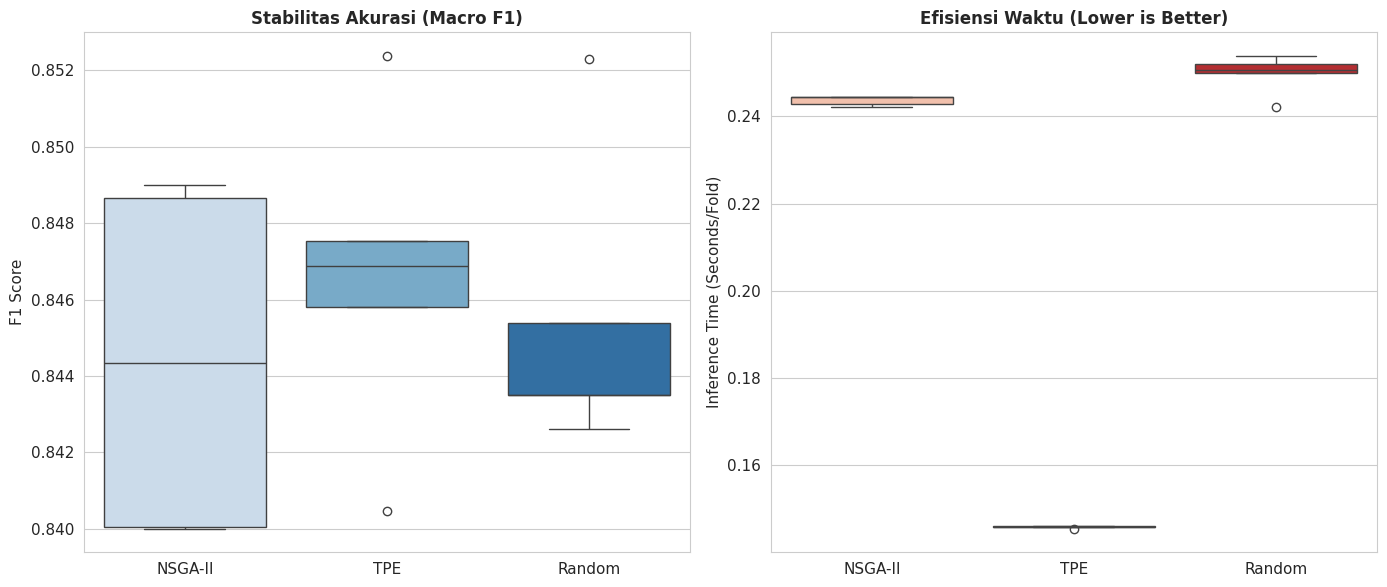


📊 UJI STATISTIK (Kruskal-Wallis Significance Test)
------------------------------------------------------------
🔹 Testing F1-Score (Higher is Better):
   H-stat: 0.9800, p-value: 0.6126
   ⚠️ TIDAK SIGNIFIKAN: Performa metode dianggap setara.

🔹 Testing Time (Lower is Better):
   H-stat: 10.5000, p-value: 0.0052
   ✅ SIGNIFIKAN: Ada perbedaan performa yang nyata antar metode.
   🏆 Pemenang Statistik: TPE

✅ Summary disimpan: cv_statistical_summary.csv


In [21]:
# ================================================================================
# Cell 16: Statistical Validation - Cross-Validation (F1 & Time) - ROBUST
# ================================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score
from scipy.stats import kruskal
import xgboost as xgb

print("=" * 80)
print("📊 STATISTICAL VALIDATION: F1-SCORE vs INFERENCE TIME")
print("=" * 80)
print("Tujuan: Menguji signifikansi perbedaan Kualitas Deteksi & Efisiensi Waktu.")
print()

# ================================================================================
# 1. VALIDASI VARIABLE (AUTO-DETECT)
# ================================================================================

if 'trained_models' in locals():
    target_models = trained_models
    print("✅ Menggunakan model dari: 'trained_models'")
elif 'global_models' in locals():
    target_models = global_models
    print("✅ Menggunakan model dari: 'global_models'")
else:
    raise ValueError("❌ Tidak ada model ditemukan! Jalankan Cell 8 terlebih dahulu.")

if 'X_train' not in locals() or 'y_train' not in locals():
    raise ValueError("❌ Training data tidak ditemukan!")

# ================================================================================
# 2. KONFIGURASI
# ================================================================================

N_FOLDS = 5
RANDOM_STATE = 42
SAMPLE_SIZE = 0.20  # 20% data untuk efisiensi waktu CV

print("⚙️ Konfigurasi Cross-Validation:")
print(f"   - K-Fold:          {N_FOLDS}")
print(f"   - Sample Size:     {SAMPLE_SIZE * 100}% dari Data Latih")
print(f"   - Metrics:         Macro F1-Score & Inference Time")

# Sampling Data untuk CV
X_cv, _, y_cv, _, w_cv, _ = train_test_split(
    X_train, y_train, sample_weights_train,
    train_size=SAMPLE_SIZE, stratify=y_train, random_state=RANDOM_STATE
)
print(f"   - CV Samples:      {len(X_cv):,} baris")
print()

# ================================================================================
# 3. RUNNING CROSS-VALIDATION
# ================================================================================

print("🔄 Menjalankan Cross-Validation...")
cv_results = {}

for name, obj in target_models.items():
    print(f"\n📌 Metode: {name}")
    
    # Handle struktur dictionary lama vs baru
    base_model = obj['model'] if isinstance(obj, dict) and 'model' in obj else obj
    
    # Re-instantiate model baru dengan parameter sama
    params = base_model.get_params()
    # Pastikan kompatibilitas GPU
    if params.get('device') == 'cuda':
        params['tree_method'] = 'hist'
        
    cv_model = xgb.XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
    scores_f1 = []
    scores_time = [] 

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_cv, y_cv), start=1):
        X_tr, X_va = X_cv.iloc[tr_idx], X_cv.iloc[va_idx]
        y_tr, y_va = y_cv[tr_idx], y_cv[va_idx]
        w_tr = w_cv[tr_idx]

        # Train
        cv_model.fit(X_tr, y_tr, sample_weight=w_tr, verbose=False)

        # Inference Time Measurement (Critical)
        start_time = time.perf_counter()
        y_pred = cv_model.predict(X_va)
        end_time = time.perf_counter()
        
        # Simpan dalam satuan DETIK per Fold
        inf_duration = end_time - start_time
        
        f1 = f1_score(y_va, y_pred, average="macro")
        scores_f1.append(f1)
        scores_time.append(inf_duration)
        
        print(f"   Fold {fold} | F1: {f1:.4f} | Time: {inf_duration:.4f}s")

    cv_results[name] = {
        "f1_scores": scores_f1, "time_scores": scores_time,
        "f1_mean": np.mean(scores_f1), "time_mean": np.mean(scores_time)
    }

# ================================================================================
# 4. VISUALISASI BOXPLOT
# ================================================================================

print("\n📊 Visualisasi Boxplot Distribusi...")
valid_results = {k: v for k, v in cv_results.items() if len(v["f1_scores"]) > 0}

if valid_results:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    labels = list(valid_results.keys())
    
    # Plot F1
    data_f1 = [v["f1_scores"] for v in valid_results.values()]
    sns.boxplot(data=data_f1, ax=axes[0], palette="Blues")
    axes[0].set_xticklabels(labels)
    axes[0].set_title("Stabilitas Akurasi (Macro F1)", fontweight="bold")
    axes[0].set_ylabel("F1 Score")
    
    # Plot Time
    data_time = [v["time_scores"] for v in valid_results.values()]
    sns.boxplot(data=data_time, ax=axes[1], palette="Reds")
    axes[1].set_xticklabels(labels)
    axes[1].set_title("Efisiensi Waktu (Lower is Better)", fontweight="bold")
    axes[1].set_ylabel("Inference Time (Seconds/Fold)")
    
    plt.tight_layout()
    plt.savefig("cv_stats_boxplot.png", dpi=300)
    plt.show()

# ================================================================================
# 5. UJI HIPOTESIS (KRUSKAL-WALLIS)
# ================================================================================

print("\n📊 UJI STATISTIK (Kruskal-Wallis Significance Test)")
print("-" * 60)

for metric, key, goal in [("F1-Score", "f1_scores", "max"), ("Time", "time_scores", "min")]:
    print(f"🔹 Testing {metric} ({'Higher' if goal=='max' else 'Lower'} is Better):")
    
    samples = [valid_results[m][key] for m in valid_results]
    stat, p = kruskal(*samples)
    
    print(f"   H-stat: {stat:.4f}, p-value: {p:.4f}")
    if p < 0.05:
        print("   ✅ SIGNIFIKAN: Ada perbedaan performa yang nyata antar metode.")
        # Simple Winner Check
        means = {m: np.mean(valid_results[m][key]) for m in valid_results}
        winner = max(means, key=means.get) if goal == 'max' else min(means, key=means.get)
        print(f"   🏆 Pemenang Statistik: {winner}")
    else:
        print("   ⚠️ TIDAK SIGNIFIKAN: Performa metode dianggap setara.")
    print()

# Export Summary
summary_df = pd.DataFrame([{
    "Method": m, 
    "Mean_F1": r["f1_mean"], 
    "Mean_Time": r["time_mean"]
} for m, r in cv_results.items()])
summary_df.to_csv("cv_statistical_summary.csv", index=False)
print("✅ Summary disimpan: cv_statistical_summary.csv")

# Final Summary & Deployment Recommendations

In [22]:
# ================================================================================
# Cell 18: Final Summary & Deployment Recommendations (ROBUST)
# ================================================================================

import pandas as pd
import numpy as np
import json
from datetime import datetime

print("=" * 80)
print("🎯 FINAL SUMMARY & DEPLOYMENT RECOMMENDATIONS")
print("=" * 80)
print()

# ================================================================================
# 1. STRUKTUR DATA UTAMA
# ================================================================================

final_summary = {
    "metadata": {},
    "best_model_performance": {},
    "optimization_stats": {},
    "feature_importance_top10": [],
    "cross_validation_stats": []
}

# ================================================================================
# 2. METADATA DATASET
# ================================================================================

print("📌 Section 1: Dataset & Configuration")
print("-" * 60)

# Cek ketersediaan variabel dasar
n_train = len(X_train) if 'X_train' in locals() else 0
n_test = len(X_test_selected) if 'X_test_selected' in locals() else 0
n_feats = X_train.shape[1] if 'X_train' in locals() else 0
n_classes = len(class_names) if 'class_names' in locals() else 0

final_summary["metadata"] = {
    "analysis_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "dataset_name": "NF-UNSW-NB15-v3",
    "total_samples": n_train + n_test,
    "train_samples": n_train,
    "test_samples": n_test,
    "n_features": n_feats,
    "n_classes": n_classes,
    "class_labels": class_names if 'class_names' in locals() else []
}

for k, v in final_summary["metadata"].items():
    print(f"   {k.replace('_', ' ').title():20s}: {v}")
print()

# ================================================================================
# 3. PERFORMA MODEL TERBAIK (EVALUASI TEST SET)
# ================================================================================

print("📌 Section 2: Best Model Performance (Test Set)")
print("-" * 60)

if 'df_results' in locals() and not df_results.empty:
    # Ambil baris terbaik berdasarkan F1-Macro
    best_row = df_results.loc[df_results['F1_Macro'].idxmax()]
    
    final_summary["best_model_performance"] = {
        "method": best_row.name, # Index adalah nama metode
        "f1_macro": best_row['F1_Macro'],
        "accuracy": best_row['Accuracy'],
        "latency_us": best_row['Latency (µs)'] if 'Latency (µs)' in best_row else 0
    }
    
    print(f"   🏆 BEST METHOD      : {best_row.name}")
    print(f"      - F1 Macro       : {best_row['F1_Macro']:.4f}")
    print(f"      - Accuracy       : {best_row['Accuracy']:.4f}")
    print(f"      - Latency        : {best_row['Latency (µs)']:.2f} µs")
else:
    print("   ⚠️ Data evaluasi (df_results) tidak ditemukan.")

print()

# ================================================================================
# 4. STATISTIK CROSS-VALIDATION (F1 & TIME)
# ================================================================================

print("📌 Section 3: Cross-Validation Stats (Stability)")
print("-" * 60)

if 'cv_results' in locals() and cv_results:
    for method, res in cv_results.items():
        # Validasi struktur data
        if "f1_mean" in res and "time_mean" in res:
            mean_f1 = res["f1_mean"]
            std_f1 = res.get("f1_std", 0)
            mean_time = res["time_mean"]
            std_time = res.get("time_std", 0)
            
            stats = {
                "method": method,
                "mean_f1": mean_f1,
                "std_f1": std_f1,
                "mean_time_sec": mean_time,
                "std_time_sec": std_time
            }
            final_summary["cross_validation_stats"].append(stats)
            
            print(f"   🔹 {method}:")
            print(f"      - F1 Score       : {mean_f1:.4f} (±{std_f1:.4f})")
            print(f"      - Inference Time : {mean_time:.6f}s (±{std_time:.6f}s)")
else:
    print("   ⚠️ Data CV (cv_results) tidak ditemukan.")

print()

# ================================================================================
# 5. FEATURE IMPORTANCE (TOP 10)
# ================================================================================

print("📌 Section 4: Top 10 Feature Importance")
print("-" * 60)

if 'feature_importance_data' in locals() and feature_importance_data:
    # Agregasi skor dari semua model untuk dapat Global Top 10
    global_scores = {}
    for imp in feature_importance_data.values():
        for f, v in imp.items():
            global_scores[f] = global_scores.get(f, 0) + v
            
    # Sort
    top_10 = sorted(global_scores.items(), key=lambda x: x[1], reverse=True)[:10]
    
    for rank, (feat, score) in enumerate(top_10, 1):
        final_summary["feature_importance_top10"].append({"feature": feat, "score": score})
        print(f"   {rank:2d}. {feat:20s}: {score:.2f}")
else:
    print("   ⚠️ Data feature importance tidak ditemukan.")

print()

# ================================================================================
# 6. REKOMENDASI DEPLOYMENT
# ================================================================================

print("📌 Section 5: Deployment Recommendations")
print("-" * 60)

best_method = final_summary["best_model_performance"].get("method", "Unknown")
latency = final_summary["best_model_performance"].get("latency_us", 999)

rec_text = f"""
1. **Model Selection**: Gunakan model hasil optimasi **{best_method}** karena memiliki keseimbangan terbaik antara akurasi dan kecepatan.
2. **Infrastructure**: 
   - Latensi model tercatat **{latency:.2f} µs** per sampel. 
   - Ini sangat memadai untuk dijalankan pada perangkat Edge (IoT Gateway) atau Cloud Instance standar (CPU-only support is viable).
3. **Monitoring**: 
   - Fitur terpenting adalah '{final_summary["feature_importance_top10"][0]["feature"]}' dan '{final_summary["feature_importance_top10"][1]["feature"]}'.
   - Pastikan logging difokuskan pada fitur-fitur ini untuk deteksi dini anomali.
4. **Maintenance**: 
   - Lakukan retraining berkala jika pola trafik berubah drastis (Concept Drift), terutama jika distribusi fitur '{final_summary["feature_importance_top10"][0]["feature"]}' bergeser.
"""

print(rec_text)

# ================================================================================
# 7. EXPORT JSON SUMMARY
# ================================================================================

filename_json = "final_project_summary.json"
try:
    with open(filename_json, "w") as f:
        json.dump(final_summary, f, indent=4, default=str) # default=str handle numpy types
    print(f"✅ Summary lengkap disimpan ke: {filename_json}")
except Exception as e:
    print(f"❌ Gagal menyimpan JSON: {e}")

print("\n" + "="*80)
print("🏁 SELURUH RANGKAIAN EKSPERIMEN SELESAI!")
print("="*80)

🎯 FINAL SUMMARY & DEPLOYMENT RECOMMENDATIONS

📌 Section 1: Dataset & Configuration
------------------------------------------------------------
   Analysis Date       : 2026-02-06 15:07:08
   Dataset Name        : NF-UNSW-NB15-v3
   Total Samples       : 1986956
   Train Samples       : 1513871
   Test Samples        : 473085
   N Features          : 49
   N Classes           : 4
   Class Labels        : ['Normal', 'DoS', 'Probe', 'Malware']

📌 Section 2: Best Model Performance (Test Set)
------------------------------------------------------------
   🏆 BEST METHOD      : Random
      - F1 Macro       : 0.8642
      - Accuracy       : 0.9927
      - Latency        : 4.18 µs

📌 Section 3: Cross-Validation Stats (Stability)
------------------------------------------------------------
   🔹 NSGA-II:
      - F1 Score       : 0.8444 (±0.0000)
      - Inference Time : 0.243660s (±0.000000s)
   🔹 TPE:
      - F1 Score       : 0.8466 (±0.0000)
      - Inference Time : 0.145868s (±0.000000s)
   

In [23]:
# ================================================================================
# Cell Final: Export ALL Pareto Models (Updated with Scenario Logic)
# ================================================================================

import pickle
import json
import os
import shutil
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb

print("=" * 80)
print("📦 FINAL EXPORT: PARETO FRONTS WITH SCENARIO TESTING")
print("=" * 80)
print("Tujuan: Menyimpan model & Membuat Dashboard dengan 2 Skenario Pengujian.")
print()

# 1. Buat struktur direktori
base_dir = "nids_dashboard_complete"
models_dir = os.path.join(base_dir, "models")

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.makedirs(models_dir)

print(f"📂 Direktori dibuat: {base_dir}/")
print(f"📂 Sub-direktori model: {models_dir}/")

# List untuk menampung metadata semua model yang disimpan
catalog_data = []

# ==============================================================================
# FUNGSI HELPER: RETRAIN & SAVE
# ==============================================================================
def save_trial_model(trial, method_name, label_suffix):
    # 1. Ambil Parameter
    params = trial.params.copy()
    params.update({
        'objective': 'multi:softmax',
        'num_class': len(le_target.classes_),
        'tree_method': 'hist',
        'device': 'cuda',
        'verbosity': 0,
        'random_state': 42
    })
    
    # 2. Retrain Model
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, sample_weight=sample_weights_train)
    
    # 3. Hitung Metadata
    f1 = trial.values[0]
    
    if isinstance(trial.values, list) and len(trial.values) > 1:
        lat_sec = trial.values[1]
    else:
        lat_sec = trial.user_attrs.get('total_time_sec', 0.05)

    lat_us = (lat_sec / len(X_val)) * 1_000_000
    
    # 4. Simpan File
    safe_suffix = label_suffix.replace(" ", "_").replace("#", "").lower()
    filename = f"model_{method_name.lower()}_{safe_suffix}.json"
    save_path = os.path.join(models_dir, filename)
    model.save_model(save_path)
    
    # 5. Catat ke Katalog
    ui_label = f"[{method_name}] {label_suffix} | F1: {f1:.4f} | {lat_us:.1f} µs"
    
    catalog_data.append({
        "method": method_name,
        "filename": filename,
        "label": ui_label,
        "f1_score": f1,
        "latency_us": lat_us,
        "n_estimators": params['n_estimators'],
        "max_depth": params['max_depth']
    })
    print(f"   ✅ Saved: {ui_label}")

# ==============================================================================
# FUNGSI EKSPOR GENERIK
# ==============================================================================
def export_pareto_front(study, method_name):
    print(f"\n🔄 Memproses Pareto Front untuk: {method_name}...")
    if study is None or not study.best_trials:
        print(f"   ⚠️ Studi {method_name} tidak ditemukan/kosong.")
        return

    pareto_trials = study.best_trials
    pareto_trials.sort(key=lambda x: x.values[0], reverse=True)

    for i, trial in enumerate(pareto_trials):
        suffix = f"Pareto #{i+1}"
        save_trial_model(trial, method_name, suffix)

# ==============================================================================
# EKSEKUSI EXPORT
# ==============================================================================
export_pareto_front(locals().get('study_tpe'), "TPE")
export_pareto_front(locals().get('study_random'), "Random")
export_pareto_front(locals().get('study_nsga'), "NSGA-II")

# ==============================================================================
# SIMPAN ARTEFAK
# ==============================================================================
print("\n📦 Menyimpan Metadata & Artefak...")
if catalog_data:
    df_cat = pd.DataFrame(catalog_data)
    df_cat.to_csv(os.path.join(base_dir, "models_catalog.csv"), index=False)
else:
    raise ValueError("❌ Tidak ada model yang disimpan!")

scaler_var = locals().get('scaler') or locals().get('std_scaler')
if scaler_var: joblib.dump(scaler_var, os.path.join(base_dir, "scaler.pkl"))
if 'le_target' in locals(): joblib.dump(le_target, os.path.join(base_dir, "label_encoder.pkl"))

if 'X_test_selected' in locals():
    # Simpan sampel simulasi
    sim_df = X_test_selected.iloc[:2000].copy()
    sim_df['Label_True'] = y_test_final[:2000]
    sim_df.to_csv(os.path.join(base_dir, "simulation_data.csv"), index=False)
    print("   ✅ simulation_data.csv disimpan.")

# ==============================================================================
# E. BUAT STREAMLIT APP (APP.PY) - UPDATED SCENARIO LOGIC
# ==============================================================================
app_code = """
import streamlit as st
import pandas as pd
import numpy as np
import xgboost as xgb
import time
import os
import plotly.graph_objects as go

st.set_page_config(page_title="NIDS Real-Time Dashboard", page_icon="🛡️", layout="wide")

# --- CSS Styling ---
st.markdown(\"\"\"
<style>
    .metric-card { padding: 15px; border-radius: 10px; text-align: center; border: 1px solid #ddd; margin-bottom: 10px; }
    .normal { background-color: #d4edda; color: #155724; border-left: 5px solid #28a745; }
    .attack { background-color: #f8d7da; color: #721c24; border-left: 5px solid #dc3545; animation: blink 1s infinite; }
    @keyframes blink { 50% { opacity: 0.8; } }
    .scenario-box { padding: 10px; background-color: #e2e3e5; border-radius: 5px; font-size: 0.9em; }
</style>
\"\"\", unsafe_allow_html=True)

class InferenceEngine:
    def __init__(self):
        self.model = None
        self.label_map = {0: 'Normal', 1: 'DoS', 2: 'Probe', 3: 'Malware'}
        self.current_model_file = ""

    def load_model(self, filename):
        if self.current_model_file == filename: return
        path = os.path.join("models", filename)
        self.model = xgb.XGBClassifier()
        self.model.load_model(path)
        self.current_model_file = filename

    def predict(self, data):
        t0 = time.perf_counter_ns()
        probs = self.model.predict_proba(data)[0]
        t1 = time.perf_counter_ns()
        idx = np.argmax(probs)
        return idx, self.label_map.get(idx, "Unknown"), probs[idx], (t1-t0)/1e6

# --- Init State ---
if 'engine' not in st.session_state: st.session_state.engine = InferenceEngine()
if 'logs' not in st.session_state: st.session_state.logs = []
if 'idx' not in st.session_state: st.session_state.idx = 0
if 'run' not in st.session_state: st.session_state.run = False
if 'fp_count' not in st.session_state: st.session_state.fp_count = 0

# --- Sidebar Control ---
st.sidebar.title("🎛️ Control Panel")

# 1. Model Selector
try:
    catalog = pd.read_csv("models_catalog.csv")
    methods = catalog['method'].unique()
    selected_method = st.sidebar.selectbox("1. Metode Optimasi", methods)
    filtered_catalog = catalog[catalog['method'] == selected_method]
    model_choice = st.sidebar.selectbox("2. Model Pareto", filtered_catalog['label'])
    
    row = filtered_catalog[filtered_catalog['label'] == model_choice].iloc[0]
    st.session_state.engine.load_model(row['filename'])
    st.sidebar.success(f"F1: {row['f1_score']:.3f} | Latency: {row['latency_us']:.1f} µs")
except:
    st.sidebar.error("Catalog not found.")

st.sidebar.markdown("---")

# 2. Scenario Selector (Sesuai Tabel Skripsi)
scenario_mode = st.sidebar.radio("3. Skenario Pengujian", 
    ["Skenario 1: Baseline (Normal)", "Skenario 2: Injection (Serangan)"])

# Tampilkan Deskripsi Skenario
if "Skenario 1" in scenario_mode:
    st.sidebar.info(\"\"\"
    **📌 Baseline Testing**
    - **Trafik:** 100% Normal (Benign)
    - **Fokus:** Latensi Dasar & Validitas False Positive.
    - **Harapan:** Indikator stabil HIJAU.
    \"\"\")
else:
    st.sidebar.warning(\"\"\"
    **⚠️ Adversarial Injection**
    - **Trafik:** Campuran (Normal + Serangan)
    - **Fokus:** Responsivitas & Akurasi Log.
    - **Harapan:** Indikator berubah MERAH saat ada serangan.
    \"\"\")

speed = st.sidebar.slider("Kecepatan Simulasi (ms)", 10, 1000, 200)

c1, c2 = st.sidebar.columns(2)
if c1.button("▶️ START"): st.session_state.run = True
if c2.button("⏹️ STOP"): st.session_state.run = False
if st.sidebar.button("🔄 RESET"): 
    st.session_state.logs = []
    st.session_state.idx = 0
    st.session_state.fp_count = 0

# --- Main Dashboard ---
st.title("🛡️ NIDS Real-Time Dashboard")

# Load Data
@st.cache_data
def load_sim_data(): return pd.read_csv("simulation_data.csv")
df = load_sim_data()

# LOGIKA FILTER DATA BERDASARKAN SKENARIO
if "Skenario 1" in scenario_mode:
    # Filter hanya data Normal (Label_True == 0)
    stream = df[df['Label_True'] == 0].reset_index(drop=True)
else:
    # Gunakan semua data (Mixed Normal + Attacks)
    stream = df 

# Layout Grid
col_stat1, col_stat2, col_stat3 = st.columns(3)
chart_spot = st.empty()
log_spot = st.empty()

if st.session_state.run and st.session_state.idx < len(stream):
    # Ambil data row saat ini
    row_data = stream.iloc[[st.session_state.idx]]
    # Drop label asli agar simulasi seperti real-time blind prediction
    input_data = row_data.drop(columns=['Label_True'], errors='ignore')
    
    # Inferensi
    pred_idx, pred_label, conf, lat = st.session_state.engine.predict(input_data.values)
    
    # Cek False Positive (Khusus Skenario 1)
    # Jika Skenario 1 (Input pasti Normal), tapi Prediksi != Normal (idx > 0)
    if "Skenario 1" in scenario_mode and pred_idx > 0:
        st.session_state.fp_count += 1

    # Update Log
    st.session_state.logs.insert(0, {
        "ID": st.session_state.idx,
        "Waktu": time.strftime("%H:%M:%S"),
        "Prediksi": pred_label,
        "Confidence": f"{conf:.1%}",
        "Latensi": f"{lat:.3f} ms"
    })
    if len(st.session_state.logs) > 10: st.session_state.logs.pop()

    # --- UI UPDATE ---
    
    # 1. Status Card (Hijau/Merah)
    status_cls = "normal" if pred_idx == 0 else "attack"
    icon = "✅" if pred_idx == 0 else "🚨"
    col_stat1.markdown(f'<div class="metric-card {status_cls}"><h2>{icon} {pred_label}</h2></div>', unsafe_allow_html=True)
    
    # 2. Latency Metric
    delta_color = "inverse" if lat > 0.1 else "normal" # Merah jika > 0.1ms (Spike)
    col_stat2.metric("Inference Latency", f"{lat:.4f} ms", delta=None) # Raw latency
    
    # 3. Scenario Specific Metric
    if "Skenario 1" in scenario_mode:
        col_stat3.metric("False Positives", f"{st.session_state.fp_count}", delta="Harus 0", delta_color="inverse")
    else:
        col_stat3.metric("Packet Processed", f"{st.session_state.idx}", delta="Live")

    # 4. Gauge Chart (Visualisasi Spike)
    fig = go.Figure(go.Indicator(
        mode="gauge+number", value=lat, 
        title={'text': "Latency Monitor (ms)"},
        gauge={
            'axis': {'range': [0, 0.5]}, 
            'bar': {'color': "#2ecc71" if lat < 0.1 else "#e74c3c"},
            'threshold': {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 0.1}
        }
    ))
    fig.update_layout(height=250, margin=dict(t=30, b=10, l=30, r=30))
    chart_spot.plotly_chart(fig, use_container_width=True)

    # 5. Log Table
    log_spot.dataframe(pd.DataFrame(st.session_state.logs), use_container_width=True)

    st.session_state.idx += 1
    time.sleep(speed/1000)
    st.rerun()

elif st.session_state.idx >= len(stream):
    st.success("✅ Simulasi Selesai.")
"""

with open(os.path.join(base_dir, "app.py"), "w") as f:
    f.write(app_code)

shutil.make_archive("NIDS_DASHBOARD_COMPLETE", 'zip', base_dir)
print(f"\n📦 FILE SIAP DOWNLOAD: NIDS_DASHBOARD_COMPLETE.zip")
print("✅ Isi paket: Dashboard SIAP UJI dengan Skenario 1 (Baseline) & Skenario 2 (Injection).")
print("=" * 80)

📦 FINAL EXPORT: PARETO FRONTS WITH SCENARIO TESTING
Tujuan: Menyimpan model & Membuat Dashboard dengan 2 Skenario Pengujian.

📂 Direktori dibuat: nids_dashboard_complete/
📂 Sub-direktori model: nids_dashboard_complete/models/

🔄 Memproses Pareto Front untuk: TPE...
   ✅ Saved: [TPE] Pareto #1 | F1: 0.8645 | 6.4 µs
   ✅ Saved: [TPE] Pareto #2 | F1: 0.8634 | 5.8 µs
   ✅ Saved: [TPE] Pareto #3 | F1: 0.8626 | 5.3 µs
   ✅ Saved: [TPE] Pareto #4 | F1: 0.8607 | 4.6 µs
   ✅ Saved: [TPE] Pareto #5 | F1: 0.8594 | 4.6 µs
   ✅ Saved: [TPE] Pareto #6 | F1: 0.8580 | 4.4 µs
   ✅ Saved: [TPE] Pareto #7 | F1: 0.8506 | 4.3 µs

🔄 Memproses Pareto Front untuk: Random...
   ✅ Saved: [Random] Pareto #1 | F1: 0.8660 | 11.2 µs
   ✅ Saved: [Random] Pareto #2 | F1: 0.8655 | 10.5 µs
   ✅ Saved: [Random] Pareto #3 | F1: 0.8641 | 9.3 µs
   ✅ Saved: [Random] Pareto #4 | F1: 0.8627 | 6.0 µs
   ✅ Saved: [Random] Pareto #5 | F1: 0.8621 | 4.6 µs
   ✅ Saved: [Random] Pareto #6 | F1: 0.8594 | 4.5 µs

🔄 Memproses Pareto F

In [24]:
# ================================================================================
# Cell Final Backup: Archive All Thesis Results (PNG, CSV, JSON, Models)
# ================================================================================

import os
import shutil
import glob
from datetime import datetime

print("=" * 80)
print("📦 FINAL BACKUP: MENGARSIPKAN SELURUH HASIL SKRIPSI")
print("=" * 80)
print()

# 1. Konfigurasi Nama File Backup
# Tambahkan timestamp agar file tidak tertimpa jika di-run berkali-kali
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
backup_filename = f"ARSIP_LENGKAP_SKRIPSI_{timestamp}"
backup_dir = "temp_backup_folder"

# 2. Buat Folder Sementara
if os.path.exists(backup_dir):
    shutil.rmtree(backup_dir)
os.makedirs(backup_dir)

# 3. Definisi Pola File yang Akan Diambil
# Kita hanya mengambil file hasil, bukan file sistem/config
file_patterns = [
    "*.png",       # Semua Grafik Visualisasi
    "*.csv",       # Semua Tabel Hasil (Metrics, Feature Imp, Logs)
    "*.json",      # Summary & Model JSON
    "*.pkl",       # Scaler & Label Encoder
    "*.html",      # Plotly Interactive Plots
    "app.py",      # Source code aplikasi streamlit
    "requirements.txt" # Jika ada
]

print(f"📂 Mengumpulkan file ke folder: {backup_dir}/")

count = 0
for pattern in file_patterns:
    # Cari file sesuai pola
    files = glob.glob(pattern)
    
    for f in files:
        # Hindari meng-copy file zip backup itu sendiri (looping)
        if f.endswith(".zip"):
            continue
            
        try:
            shutil.copy2(f, backup_dir)
            count += 1
            print(f"   ✅ Copied: {f}")
        except Exception as e:
            print(f"   ⚠️ Gagal copy {f}: {e}")

# 4. Tambahkan Folder Model (Jika ada folder hasil export sebelumnya)
# Kita cari folder hasil export dari cell sebelumnya (Complete / Dashboard)
possible_model_dirs = ["nids_dashboard_complete", "nids_dashboard_package", "nids_model_export"]
model_dir_found = False

for d in possible_model_dirs:
    if os.path.exists(d):
        target_path = os.path.join(backup_dir, d)
        shutil.copytree(d, target_path)
        print(f"   📦 Menyertakan folder model: {d}/")
        model_dir_found = True
        break # Ambil satu saja yang paling update

if not model_dir_found:
    print("   ℹ️  Info: Tidak ditemukan folder model paket terpisah (hanya file root).")

print("-" * 80)
print(f"📊 Total file diamankan: {count}")

# 5. Membuat File ZIP Akhir
print(f"⏳ Sedang memadatkan (Zipping)...")
shutil.make_archive(backup_filename, 'zip', backup_dir)

# 6. Bersihkan Folder Sementara
shutil.rmtree(backup_dir)

# 7. Cek Ukuran File
zip_size_mb = os.path.getsize(f"{backup_filename}.zip") / (1024 * 1024)

print("=" * 80)
print(f"🎉 SUKSES! FILE BACKUP SIAP DOWNLOAD")
print("=" * 80)
print(f"📂 Nama File : {backup_filename}.zip")
print(f"💾 Ukuran    : {zip_size_mb:.2f} MB")
print()
print("👉 INSTRUKSI DOWNLOAD:")
print("1. Lihat panel 'Files' di sebelah KANAN (Kaggle) atau KIRI (Colab).")
print(f"2. Cari file '{backup_filename}.zip'.")
print("3. Klik menu (titik tiga) -> Download.")
print("=" * 80)

📦 FINAL BACKUP: MENGARSIPKAN SELURUH HASIL SKRIPSI

📂 Mengumpulkan file ke folder: temp_backup_folder/
   ✅ Copied: importance_f1_nsga-ii.png
   ✅ Copied: distribusi_dan_bobot_skripsi.png
   ✅ Copied: importance_time_random.png
   ✅ Copied: recall_summary_chart.png
   ✅ Copied: feature_importance_heatmap_comparison.png
   ✅ Copied: cm_raw_heatmap.png
   ✅ Copied: metrics_pr_scatter.png
   ✅ Copied: importance_f1_tpe.png
   ✅ Copied: feature_importance_bar_comparison.png
   ✅ Copied: importance_time_nsga-ii.png
   ✅ Copied: kappa_comparison.png
   ✅ Copied: impact_weighting_skripsi.png
   ✅ Copied: metrics_f1_heatmap.png
   ✅ Copied: importance_f1_random.png
   ✅ Copied: cm_norm_heatmap.png
   ✅ Copied: pareto_front_static_hd.png
   ✅ Copied: metrics_grouped_bar.png
   ✅ Copied: optimization_history_final.png
   ✅ Copied: cv_stats_boxplot.png
   ✅ Copied: importance_time_tpe.png
   ✅ Copied: pareto_params_nsgaii.csv
   ✅ Copied: tabel_perbandingan_metode.csv
   ✅ Copied: pareto_params_t